<center>

# Evaluating Spatial Accessibility and Social Equity of Urban Public Facilities: A Case Study in New York City

## Final Project: LSE Course ST445-Managing and Visualizing Data, 24/25

### Yuanpeng Chen, Zerui Zhou, Chenyang Zhao

</center>


## Prerequisites of Notebook

In order to conduct this project's exploratory data analysis (EDA), please follow the preparations **step-by-step** before executing all of the code cells:

**(1) Check the Python Version of the Environment:** 
- Ensure that the Python version of your environment is **3.10** or higher to maintain compatibility with the packages required in this project (e.g., `geopandas`, `shap`, etc.).

**(2) Install the `geopandas` Package of Lastest Version if Possible:**
- Older versions of `geopandas` and its modules (`PROJ` and `pyproj`) do not support spatial data reprojection which will be used in our project's data preprocessing. Please ensure that these dependencies are up to date (`PROJ >= 9.5.1`, `pyproj >= 3.7.0`). You can check the versions of `geopandas`, `PROJ`, and `pyproj` using `geopandas.show_versions()`.

**(3) Apply an App Token from [NYC Open Data](https://opendata.cityofnewyork.us/)**
- Register an [NYC Open Data Account](https://data.cityofnewyork.us/login)
- Click **My Profile**, **Edit Profile**, and **Developer Settings** in order.
- Click **Create New App Token**, enter basic information about your new token (e.g. Token Name, Description).
- Token created, copy the Token code, `kMA3pLN5r66BAnhG4hQvEr8Mi` for example.

**(4) Request a U.S. Census Data API Key**
- Register a U.S. Census Data [API Key](https://api.census.gov/data/key_signup.html)
- Enter your organization name and youe email address, any email is acceptable, including personal, work, or educational emails.
- Copy your API key, `c749e019b8b8dcd18a1a93b9c616c0751b78d8eb` for example.

In [1]:
# Import Necessary Packages
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sodapy import Socrata
import osmnx as ox
from census import Census
from us import states
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import xgboost as xgb
import shap
import shapely
import kagglehub
import shutil
import os
from shapely.geometry import shape
from getpass import getpass
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn import set_config
set_config(display='text')
ox.settings.use_cache = False

In [2]:
# Check the versions of the packages and the dependencies of geopandas
# gpd.show_versions()

## Content <br><br>

* [**1. Introduction**](#1)
    * [1.1 Research Background](#1_1)
    * [1.2 Research Objectives and Questions](#1_2)
    * [1.3 Description of Dataset](#1_3)
* [**2. Data Acquisition and Preprocessing**](#2)
    * [2.1 The Boundaries of NYC by Boroughs and Census Tracts](#2_1)
    * [2.2 Roads and Paths in NYC](#2_2)
    * [2.3 Geographical Points of Public Facilities](#2_3)
    * [2.4 Socio-economic Indicators from ACS](#2_4)
    * [2.5 Other Indicators Generated by Current Acquired Data](#2_5)
* [**3. Data Visualization and Analysis**](#3)
    * [3.1 Spatial Accessibility Distribution of Different Public Facilities](#3_1)
    * [3.2 Equity Assessment of Different Boroughs](#3_2)
    * [3.3 Equity Assessment of Different Demographic Groups](#3_3)
    * [3.4 Evaluation of Socio-economic Factors’ Impact on Facility Accessibility](#3_4)
* [**4. Conclusion**](#4)
* [**References**](#5)

## 1. Introduction <a id="1"></a>

<a id="1_1"></a>
### 1.1 Research Background

In recent years, urban areas worldwide have experienced rapid and high-quality development, especially in cities' physical infrastructure, public facilities, and residents' quality of life. According to predictions by the **United Nations**, 68% of the global population will be living in urban areas by 2050 ( *United Nations, 2018* ). However, as cities continue to grow and expand, the concentration of wealth and income growth among the highest earners will exacerbate economic inequalities, leading to more intense competition for limited urban resources ( *Sarkar et al., 2024* ). This indicates that urban development has to face the dilemma of inequality of public resources, including public facilities such as education, medical care, transportation, cultural & historical sites, and so on ( *Xu et al., 2022* ).

Hence, it is of great research importance to:

- Quantify the accessibility levels of multiple public facilities and analyze their spatial distribution patterns.
- Assess the equity levels of various facilities based on different geographical locations and demographic groups.
- Evaluate the impacts of various socio-economic factors on the accessibility levels of public facilities.

Such research can assist policymakers and urban planners in identifying spatial and demographic disparities in public resource access, understanding the underlying mechanisms and contributing indicators of these inequalities, and ultimately promoting **social justice** as well as the long-term **sustainable city development**.

<a id="1_2"></a>
### 1.2 Research Objectives and Questions

Based on the research context, this project aims to conduct a comprehensive analysis of equitable access to two types of public facilities (education and health care) in New York City (NYC) on a ["census tract"](https://en.wikipedia.org/wiki/Census_tract) scale. NYC is the largest city in the U.S. with substantial metropolitan economy and diverse demographic composition ( *Baghestani et al., 2024* ), which make it an ideal choice to be selected as the study area for our analysis. The study also seeks to provide meaningful insights into the spatial and statistical characteristics of accessibility scores and the (in)equality status for both facilities, and to investigate how different socio-economic factors contribute to their accessibility patterns in NYC. To achieve these objectives, the research will be organized into three parts, each answering specific research questions as follows:

**Facility accessibility-based spatial distribution analysis:**  
- What is the spatial distribution of accessibility to different types of public facilities across all census tracts in NYC? 
- What are the overall geographical and numerical patterns of these accessibility levels/scores?

**Equity assessment across different NYC boroughs and population groups:**  
- Is the distribution of accessibility to different facilities equitable across all "boroughs" of NYC? In other words, is access to specific public facilities fairly distributed among all the "five" boroughs in NYC?
- Is the accessibility equitable across different "demographic groups" (e.g., by race or income level)? Do demographic groups of different races and personal incomes have equal access to the same public facilities?

**Importance assessment of relevant factors:**  
- What is the contribution or importance level of various socio-economic factors (e.g., population density, income, transportation access, poverty levels, facility density) to the accessibility of different public facilities?
- Does the importance ranking of these selected factors vary across different types of public facilities in influencing their accessibility levels?

<a id="1_3"></a>
### 1.3 Description of Dataset

This project acquires and utilizes multiple open-source datasets, including **points of interest (POI)** data with geographical coordinates, geospatial data such as **district polygons** and **traffic lines**, and **tabular data** containing socio-economic indicators. A summary of the datasets used in this research is demonstrated in the table below:

### Quick Infomation about the Dataset
|No.|Name|Data Type|Source|Data Processing Format|Data Access Method|
|---|---|---|---|---|---|
|1|NYC Borough Boundaries|Spatial vector data (polygon)|[NYC Borough Boundaries, Kaggle](https://www.kaggle.com/datasets/dataembassy/nyc-borough-boundaries)|GeoDataFrame|`kagglehub` Python Package|
|2|NYC Latest Census Tracts Boundaries|Spatial vector data (polygon)|[2020 Census Tracts, NYC Open Data](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts/63ge-mke6/about_data)|GeoDataFrame|[NYC Open Data APIs with SODA App Tokens](https://medium.com/analytics-vidhya/accessing-nyc-open-data-apis-with-application-tokens-6b004f8a27c8)|
|3|Roads and Paths of NYC|Spatial vector data (line)|[Open Street Map](https://www.openstreetmap.org/#map=12/40.7902/-73.9184)|GeoDataFrame|`OSMnx` Python Package|
|4|POIs of NYC Public Facilities|Geographical points|[Facilities Database, NYC Open Data](https://data.cityofnewyork.us/City-Government/Facilities-Database/ji82-xba5/about_data)|GeoDataFrame|[NYC Open Data APIs with SODA App Tokens](https://medium.com/analytics-vidhya/accessing-nyc-open-data-apis-with-application-tokens-6b004f8a27c8)|
|5|Socio-economic Indicators|Tabular data|[American Community Survey 5-Year Data](https://www.census.gov/data/developers/data-sets/acs-5year.html)|DataFrame|[U.S. Census Data API](https://www.census.gov/data/developers/guidance/api-user-guide.html)|
|6|Other Indicators|Data frame with geometry|Produced from the data 1-5|GeoDataFrame|Obtained by post-processing acquired data above|

#### Data Description & Usage

**The NYC boundaries data:**
- ***NYC borough boundaries***: spatial vector polygons representing NYC’s five boroughs (Manhattan, Bronx, Brooklyn, Queens, Staten Island). It is used for basic visualization for the study area, providing a general overview of the location, spatial extent & shapes, and geographical correlations of NYC's five boroughs.
- ***NYC census tracts boundaries***: spatial vector polygons of NYC divided into smaller census tract scales. It serves as the **foundational dataset** for the study that supports calculations of census scale accessibility scores of education & health care facilities, equity assessments, and the final importance analysis factors.

**NYC Open Street Map (OSM) roads and paths data:**
- ***OpenStreetMap (OSM)*** provides open-source and latest online global geospatial data, including district boundaries, locations, transportation networks, water bodies, land use, etc. The extracted **NYC roads and paths** dataset includes line features representing transportation roads, residential streets, and pedestrian paths within NYC.
- This dataset is used to compute **road density** (measured as the total length of roads per unit area) for each census tract, since road network density is one of the important factors influencing accessibility to public facilities ( *Liu et al., 2019* ; *Yin et al., 2018* ).

**Facility POIs:**
- The ***NYC Facilities Database*** contains geographical point data for various public facilities in NYC, including schools, hospitals, administration of government, parks/gardens, cultural & historical landmarks, and major transportation sites.
- For this study, only **education** and **healthcare** facilities were extracted for accessibility assessment at the census tract level for NYC.

**American Community Survey (ACS) socio-economic data:**
- ACS is an ongoing nationwide community survey conducted by the [U.S. Census Bureau](https://www.census.gov/), containing socio-economic data of multiple topics at the census tract level every year, including housing, income, poverty, education, employment, health insurance coverage, and so on.
- This project utilizes the [ACS 5-Year Data (2009–2023)](https://www.census.gov/data/developers/data-sets/acs-5year.html), which contains the most detailed data information on all socio-economic topics for all geographies within the U.S., including NYC. 
- We have selected **median income**, **poverty level**, and **population by race** indicators from ACS and use them for accessibility equity evaluation and factor importance analysis.

**Other indicators generated by the already accessed data:**
- Additional census tract-level indicators are generated by integrating previously acquired datasets to enrich the final factor importance analysis, including:
- (1) ***Road Density***: Generated by spatial-joining NYC census tracts data with OSM Roads and Paths lines.
- (2) ***Population Density***: Calculated by combining NYC census tracts data with ACS Total Population indicator.
- (3) ***Public Facility Density***: Generated by spatial-joining NYC census tracts with Facility POIs.
- (4) ***Poverty Ratio***: Computed by linking NYC census tracts with ACS Poverty Level data.


<a id="2"></a>
## **2. Data Acquisition and Preprocessing**


<a id="2_1"></a>
### 2.1 The Boundaries of NYC by Boroughs and Census Tracts

#### The Boundaries of Boroughs in NYC

First, before we access and preprocess the NYC [boroughs boundaries](https://www.kaggle.com/datasets/dataembassy/nyc-borough-boundaries#) data via Kagglehub, please make sure you have installed the `kagglehub` Python package in your environment, which is an open-source tool that can download public Kaggle datasets directly to your working directory.

In [2]:
# Download the NYC Boroughs Boundaries dataset to a temporary directory
path = kagglehub.dataset_download("dataembassy/nyc-borough-boundaries")

# Find the NYC Boroughs Boundaries shapefile
shapefile_path = ""
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)
            break

# Load the shapefile as a GeoDataFrame
NYC_borough = gpd.read_file(shapefile_path)


# Delete the temporary directory and its files
file_dir_path = os.path.dirname(path)
file_dir_path = os.path.dirname(file_dir_path)
file_dir_path = os.path.dirname(file_dir_path)
shutil.rmtree(file_dir_path)

# Drop unnecessary columns
NYC_borough = NYC_borough.drop(columns=["Shape_Leng", "Shape_Area"])
display(NYC_borough.head())
print("shape:", NYC_borough.shape)

100%|██████████| 640k/640k [00:00<00:00, 1.38MB/s]

Extracting files...


BoroCode       BoroName                                           geometry
0         5  Staten Island  MULTIPOLYGON (((970217.022 145643.332, 970227....
1         2          Bronx  MULTIPOLYGON (((1012821.806 229228.265, 101278...
2         4         Queens  MULTIPOLYGON (((1029606.077 156073.814, 102957...
3         3       Brooklyn  MULTIPOLYGON (((1021176.479 151374.797, 102100...
4         1      Manhattan  MULTIPOLYGON (((981219.056 188655.316, 980940....

shape: (5, 3)


**Metadata of the pre-processed NYC boroughs boundaries**

- number of rows: 5
- number of columns: 3
- Fields:

|Name|Data Type|Description|
|---|---|---|
|BoroCode|Integer|Borough Code|
|BoroName|String|Borough Name|
|geometry|geometry|multipolygon|

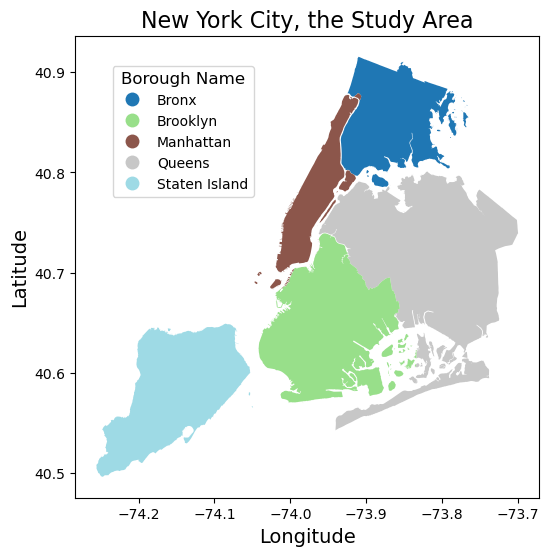

In [3]:
# Visualize the NYC Boroughs
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
NYC_borough = NYC_borough.to_crs(epsg=32618)
NYC_borough.to_crs(epsg=4326).plot(column='BoroName', legend=True, ax=ax, cmap='tab20')
plt.title("New York City, the Study Area", fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.4, 0.95))
legend.set_title("Borough Name", prop={"size": 12})
for text in legend.get_texts():
    text.set_fontsize(10)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.show()

#### The Boundaries of Census Tracts in NYC

**(1) Get the raw data, and transfer it into DataFrame**

First, in order to get datasets from NYC OpenData, please make sure you have registered a [NYC OpenData Account](https://data.cityofnewyork.us/login) and a [SODA App Token](https://support.socrata.com/hc/en-us/articles/210138558-Generating-App-Tokens-and-API-Keys), which is used to track API requests from a specific data application, the number of data requests would be limited without containing an App token in the query.

Now we are ready to get access to the NYC OpenData resources, using the NYC census tracts boundaries data as an example, please follow the steps below to get and transfer data into processable (Geo)DataFrame format:
- ***Step 1:*** Search the targeted data in the [NYC OpenData Website](https://opendata.cityofnewyork.us/data/), in this case search the "Census tracts"
- ***Step 2:*** Enter the targeted data's description [page](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts/63ge-mke6/about_data), then click the **Export** button if it has
- ***Step 3:*** Get the **API Endpoint** for the desirable dataset, in NYC 2020 Census Tracts' case, the endpoint is: https://data.cityofnewyork.us/resource/63ge-mke6.json
    - *data.cityofnewyork.us*   --Data Source Domain
    - *resource*                --Data Division
    - *7t3b-ywvw*               --Dataset Identifier of "NYC Boroughs Boundaries" dataset
    - .json                     --Returns as a JSON file
- ***Step 4:*** Get data using **SODA App Token** and **Socrata Python Tool** from **sodapy** package, and transfer it into pandas DataFrame format which is processible in Python, example is shown as follows:
- `NOTE:` If you don't have an app token, you can use mine:kMA3pLN5r66BAnhG4hQvEr8Mi

In [4]:
# Get the Census Tracts of NYC from the NYC OpenData
# Data API endpoint: https://data.cityofnewyork.us/resource/63ge-mke6.json

# 1. Imoprt the client information
# client = Socrata(Data Source Domain,              # data.cityofnewyork.us
#                   AppToken,                       # Your App token, in case you don't have one, you can enter "None" to make limited requests
#                   Username="user@example.com",    # Optional
#                   Password="AFakePassword")       # Optional

# NOTE: If you don't have an app token, you can use mine:kMA3pLN5r66BAnhG4hQvEr8Mi
APP_token = getpass("Enter your APP Token: ")
client = Socrata("data.cityofnewyork.us", APP_token)

# 2. Get the targeted data from the API, returns as a JSON object
# results = client.get(Dataset Identifier,          # A string that identifies the dataset, could be found in the dataset documentation
#                       limit=a number)             # The number of rows to return, default is 1000

# According to the data documentation, the number of census tracts in NYC is 2325, 
# so the 'limit' parameter should be set to lager than 2325
results = client.get(dataset_identifier="63ge-mke6", limit=2400)

# 3. Convert JSON to pandas DataFrame
NYC_census_tract = pd.DataFrame.from_records(results)
display(NYC_census_tract.head())
print("shape:", NYC_census_tract.shape)

the_geom ctlabel borocode  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...       1        1   
1  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   14.01        1   
2  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   14.02        1   
3  {'type': 'MultiPolygon', 'coordinates': [[[[-7...      18        1   
4  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   22.01        1   

    boroname  ct2020 boroct2020  \
0  Manhattan  000100    1000100   
1  Manhattan  001401    1001401   
2  Manhattan  001402    1001402   
3  Manhattan  001800    1001800   
4  Manhattan  002201    1002201   

                                             ntaname nta2020 cdta2020  \
0  The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1                                    Lower East Side  MN0302     MN03   
2                                    Lower East Side  MN0302     MN03   
3                                    Lower East Side  MN0302     MN03   
4                                    Lower East Side  MN0302     MN03   

                                            cdtaname        geoid  \
0  MN01 Financial District-Tribeca (CD 1 Equivalent)  36061000100   
1   MN03 Lower East Side-Chinatown (CD 3 Equivalent)  36061001401   
2   MN03 Lower East Side-Chinatown (CD 3 Equivalent)  36061001402   
3   MN03 Lower East Side-Chinatown (CD 3 Equivalent)  36061001800   
4   MN03 Lower East Side-Chinatown (CD 3 Equivalent)  36061002201   

      shape_leng     shape_area  
0  10833.0439286  1843004.52241  
1  5075.33199978  1006116.58429  
2   4459.1560187  1226206.24719  
3  6391.92117449  2399276.86435  
4  5779.06260724  1740173.87581

shape: (2325, 13)


**(2) Data Cleaning & Preprocessing**

Now we have acquired the original data in a DataFrame format, then we should convert this data into the GeoDataFrame object for visualization:

- ***Step 1:*** Check the dataset's **"geometry"** attribute to make sure there are no NaN values (invalid geometry objects) in this field
- ***Step 2:*** Transfer the DataFrame into geopandas **GeoDataFrame** with geographical information and with a initially defined [Coordinate reference system (CRS)](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/). The original CRS of the NYC OpenData Boroughs Boundaries is **EPSG:4326**, or [WGS84 geographic coordinate system](https://epsg.io/4326), whose unit of measurement is **degree**.
- ***Step 3:*** Convert the dataset's CRS to **EPSG:32618**, or [WGS 84 / UTM zone 18N system](https://epsg.io/32618), a projected coordinate system with meters as the unit of measurement. This step enable us to: 
  - Improve data accuracy: Minimizing distortion by using a **local** CRS optimized for NYC instead of a **global** one like EPSG:4326 (WGS 84)
  - Geometric calculations: Enabling measurement of spatial properties such as area and length, which are crucial for later analysis.
- ***Step 4:*** Drop unnecessary columns

In [5]:
# Check the geometry column for missing values
NYC_census_tract = NYC_census_tract[NYC_census_tract["the_geom"].notnull()]

# Convert the_geom as Shapely Geometric Objects
NYC_census_tract["geometry"] = NYC_census_tract["the_geom"].apply(lambda x: shape(x))

# Convert the DataFrame to a GeoDataFrame
NYC_census_tract = gpd.GeoDataFrame(NYC_census_tract, geometry="geometry", crs="EPSG:4326")

# Reproject the GeoDataFrame to CRS EPSG:32618
NYC_census_tract = NYC_census_tract.to_crs(epsg=32618)

# Select the necessary columns
NYC_census_tract = NYC_census_tract[["borocode", "boroname", "geoid", "geometry"]]
display(NYC_census_tract.head())
print("shape:", NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   

                                            geometry  
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...  
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...  
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...  
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...  
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...

shape: (2325, 4)


**Metadata of the pre-processed NYC census tracts boundaries**

- number of rows: 2325
- number of columns: 4
- Fields:

|Name|Data Type|Description|
|---|---|---|
|borocode|Integer|Borough Code|
|borocode|String|Borough Name|
|geoid|String|The identity number of a census tract|
|geometry|geometry|multipolygon|

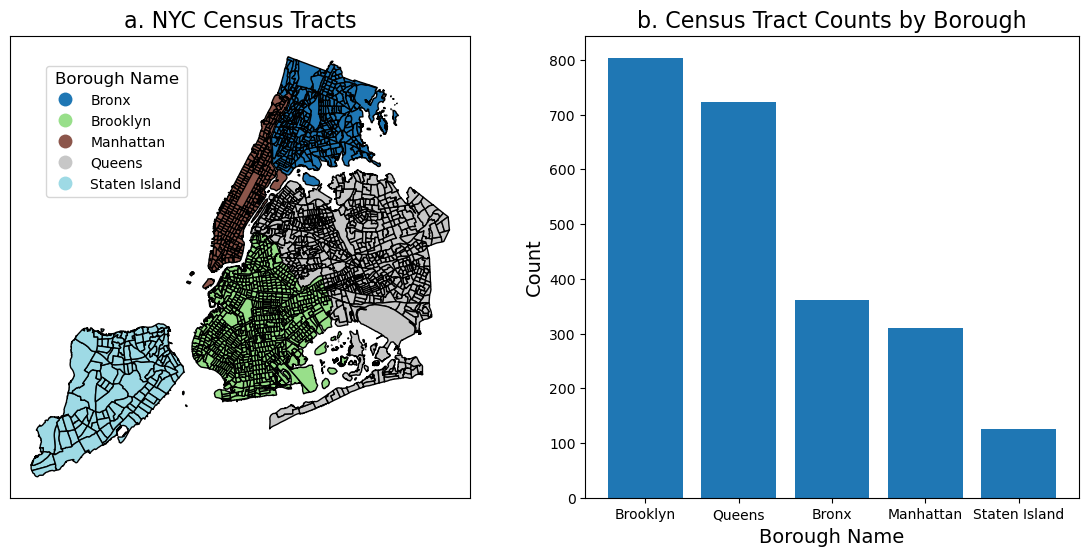

In [7]:
# Visualize the NYC Census Tracts Data
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Fig a. Plot the census tracts by borough
NYC_census_tract.plot(column='boroname',
    legend=True,
    ax=axs[0],
    cmap='tab20',
    edgecolor='black'
)
axs[0].set_title("a. NYC Census Tracts", fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])
legend = axs[0].get_legend()
legend.set_bbox_to_anchor((0.4, 0.95))
legend.set_title("Borough Name", prop={"size": 12})
for text in legend.get_texts():
    text.set_fontsize(10)

# Fig b. Plot the census tract counts by borough
borough_counts = NYC_census_tract['boroname'].value_counts().reset_index()
borough_counts.columns = ['boroname', 'census_tract_count']
axs[1].bar(
    borough_counts['boroname'],
    borough_counts['census_tract_count']
)
axs[1].set_title("b. Census Tract Counts by Borough", fontsize=16)
axs[1].set_xlabel("Borough Name", fontsize=14)
axs[1].set_ylabel("Count", fontsize=14)
axs[1].tick_params(axis='x')

plt.show()

<a id="2_2"></a>
### 2.2 Roads and Paths in NYC

**(1) Data Acquiring and Filtering**:
- First, please make sure you have installed the [**osmnx**](https://osmnx.readthedocs.io/en/stable/) Python package, which is used to easily download, model, analyze, and visualize multiple geospatial features, including street networks, from OpenStreetMap.
- Then input the interested area where we want to get data from, in NYC's case, the parameter should be ***"New York City, New York, USA"***.
- Choose the road types for later analysis, in this project, we chose the following road types that are related to transportation lines:
  - motorway: Motorway/freeway
  - trunk: Important roads, typically divided
  - primary: Primary roads, typically national
  - secondary: Secondary roads, typically regional
  - tertiary: Tertiary roads, typically local
  - residential: Roads in residential areas
  - busway: Dedicated roads for bus
- `PLEASE NOTE:` The following code cell might take more than **4 minutes** to completely execute; please be patient and avoid interrupting the execution to ensure accurate results. This is because the road dataset in NYC is extremely large, containing over 300,000 records.


In [8]:
# NOTE: It might take more than 4 minutes to run this cell

# Get the OSM roads and paths data of NYC using OSMnx
G = ox.graph_from_place('New York City, New York, USA')

# Convert the graph to GeoDataFrames
# gdg_nodes: The nodes of the roads
# gdg_edges: The edges of the roads, which are the road lines we want to extract
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Select the interested road types
road_types = ["motorway", "trunk", "primary", "secondary", "tertiary", "residential", "busway"]
NYC_road = gdf_edges[gdf_edges["highway"].apply(
    lambda x: isinstance(x, str) and x in road_types
)]

display(NYC_road.head())
print("shape:", NYC_road.shape)

osmid    highway  oneway reversed      length  \
u        v          key                                                       
39076461 274283981  0      25161349   motorway    True    False  819.501666   
39076490 277672005  0    1014007069   motorway    True    False  291.838695   
39076504 462122450  0     995490141   motorway    True    False  552.425691   
42421728 7784826657 0     195743153  secondary   False     True   11.805821   
         7784826658 0     420625573  secondary   False    False   11.769534   

                                                                  geometry  \
u        v          key                                                      
39076461 274283981  0    LINESTRING (-73.79475 40.78635, -73.79462 40.7...   
39076490 277672005  0    LINESTRING (-73.75709 40.76243, -73.75741 40.7...   
39076504 462122450  0    LINESTRING (-73.74416 40.75347, -73.74552 40.7...   
42421728 7784826657 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         7784826658 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   

                                         name lanes maxspeed  ref bridge  \
u        v          key                                                    
39076461 274283981  0    Cross Island Parkway     2   50 mph   CI    NaN   
39076490 277672005  0    Cross Island Parkway     3   50 mph   CI    NaN   
39076504 462122450  0    Cross Island Parkway     3   50 mph   CI    NaN   
42421728 7784826657 0       Central Park West   NaN   25 mph  NaN    NaN   
         7784826658 0       West 106th Street   NaN      NaN  NaN    NaN   

                        access service tunnel width junction est_width area  \
u        v          key                                                       
39076461 274283981  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
39076490 277672005  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
39076504 462122450  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
42421728 7784826657 0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
         7784826658 0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   

                        landuse  
u        v          key          
39076461 274283981  0       NaN  
39076490 277672005  0       NaN  
39076504 462122450  0       NaN  
42421728 7784826657 0       NaN  
         7784826658 0       NaN

shape: (300062, 19)


**(2) Data Cleaning & Pre-processing**
- ***Step 1:*** Checking the missing values for the geometry
- ***Step 2:*** Geo-referencing, reprojecting & Simplifying the lines
- ***Step 3:*** Selecting necessary columns

In [9]:
# Check the geometry column for missing values
NYC_road = NYC_road[NYC_road["geometry"].notnull()]

# Georeferencing & Reprojecting
NYC_road = NYC_road.set_crs(epsg=4326)
NYC_road = NYC_road.to_crs(epsg=32618)

# Simplify the geometry, set the tolerance to 10 meters
tolerance = 10
NYC_road['geometry'] = NYC_road['geometry'].simplify(tolerance)

# Select the necessary columns
NYC_road = NYC_road[['osmid', 'highway', 'geometry', 'name']]
NYC_road = NYC_road.reset_index(drop=True)
display(NYC_road.head(10))
print("shape:", NYC_road.shape)

osmid      highway                                           geometry  \
0    25161349     motorway  LINESTRING (601691.23 4515738.523, 602148.812 ...   
1  1014007069     motorway  LINESTRING (604906.239 4513128.015, 604814.414...   
2   995490141     motorway  LINESTRING (606011.533 4512148.657, 605866.196...   
3   195743153    secondary  LINESTRING (587729.044 4516859.09, 587723.438 ...   
4   420625573    secondary  LINESTRING (587729.044 4516859.09, 587718.659 ...   
5  1271523198    secondary  LINESTRING (587729.044 4516859.09, 587735.426 ...   
6     5671485  residential  LINESTRING (587607.544 4516924.975, 587602.434...   
7   195743186  residential  LINESTRING (587607.544 4516924.975, 587613.581...   
8   420625565    secondary  LINESTRING (587607.544 4516924.975, 587614.738...   
9   420625570    secondary  LINESTRING (587607.544 4516924.975, 587598.603...   

                   name  
0  Cross Island Parkway  
1  Cross Island Parkway  
2  Cross Island Parkway  
3     Central Park West  
4     West 106th Street  
5     Central Park West  
6      Manhattan Avenue  
7      Manhattan Avenue  
8     West 106th Street  
9     West 106th Street

shape: (300062, 4)


**Metadata of the pre-processed NYC roads and paths**

- number of rows: 300005
- number of columns: 4
- Fields:

|Name|Data Type|Description|
|---|---|---|
|osmid|String|The identity of a line feature|
|highway|String|Road type|
|geometry|geometry|LINESTRING|
|name|String|Name of the road/path|

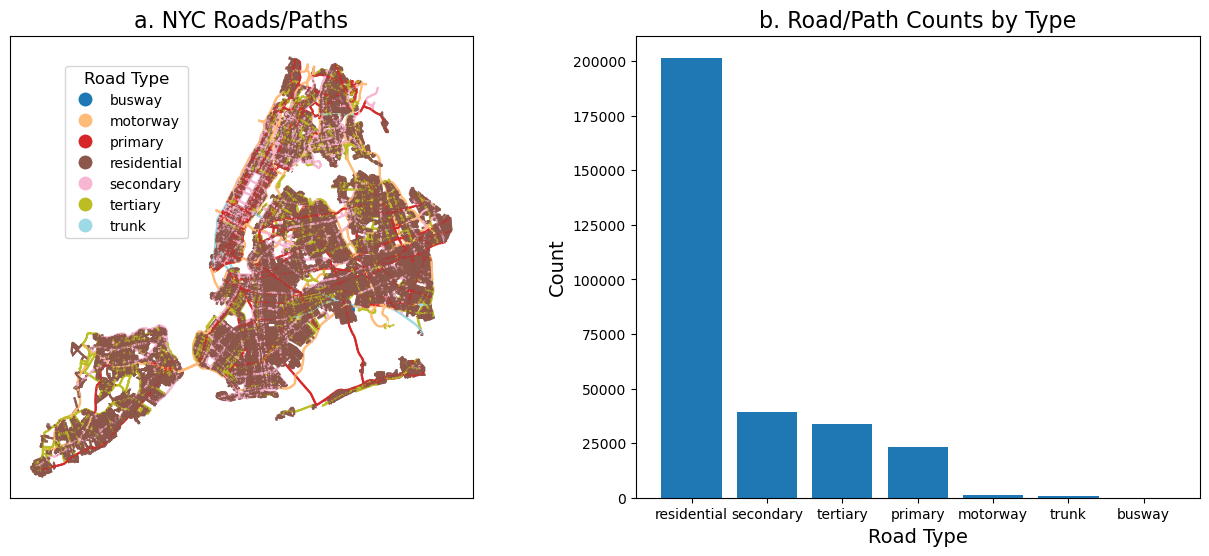

In [10]:
# Visualize the NYC Roads
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Fig a. Plot the census tracts by borough
NYC_road.plot(column='highway',
    legend=True,
    ax=axs[0],
    cmap='tab20'
)
axs[0].set_title("a. NYC Roads/Paths", fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])
legend = axs[0].get_legend()
legend.set_bbox_to_anchor((0.4, 0.95))
legend.set_title("Road Type", prop={"size": 12})
for text in legend.get_texts():
    text.set_fontsize(10)

# Fig b. Plot the road counts by type
road_counts = NYC_road['highway'].value_counts().reset_index()
road_counts.columns = ['highway', 'road_type_count']
axs[1].bar(
    road_counts['highway'],
    road_counts['road_type_count']
)
axs[1].set_title("b. Road/Path Counts by Type", fontsize=16)
axs[1].set_xlabel("Road Type", fontsize=14)
axs[1].set_ylabel("Count", fontsize=14)
axs[1].tick_params(axis='x')

plt.show()

<a id="2_3"></a>
### 2.3 Geographical Points of Public Facilities

**(1) Data Acquiring and Filtering**
- The [NYC OpenData Facilities Database's](https://data.cityofnewyork.us/City-Government/Facilities-Database/ji82-xba5/about_data) API endpoint is: https://data.cityofnewyork.us/resource/ji82-xba5.json
- There's also an [interactive map](https://capitalplanning.nyc.gov/map/facilities#10/40.7128/-74.0807) to view the distribution of multiple facilities on web.

In [11]:
# Get the points of interest (POI) of facilities in NYC from the NYC OpenData
# Data API endpoint: https://data.cityofnewyork.us/resource/ji82-xba5.json

# 1. Imoprt the client information
client = Socrata("data.cityofnewyork.us", APP_token)

# 2. Get the targeted data from the API, returns as a JSON object
# According to the data documentation the number of facility points in NYC is more than 30000, 
# so the limit parameter is set to 40000
results = client.get(dataset_identifier="ji82-xba5", limit=40000)

# 3. Convert JSON to pandas DataFrame
NYC_poi = pd.DataFrame.from_records(results)
display(NYC_poi.head())
print("shape:", NYC_poi.shape)

uid                                 facname  \
0  000081aff7e44860160371b7a6b79e9a                 I.S. 075 FRANK D. PAULO   
1  000105fd986377e37a8f95abfdbda92d        SUCCESS ACADEMY CS - BENSONHURST   
2  000186821f899fef28e05c9ca2182621  PLANNED PARENTHOOD BRONX HEALTH CENTER   
3  0002d3b5bb64af5fbc4d28e67dd33e1a                  WASHINGTON IRVING YABC   
4  00056520e4c5483e13933cda8c8a736d       MARKS JCH OF BENSONHURST DAY CAMP   

  addressnum       streetname              address           city  \
0        455  HUGUENOT AVENUE  455 HUGUENOT AVENUE  STATEN ISLAND   
1        NaN              NaN      99 AVE P-4TH FL       BROOKLYN   
2        349  EAST 149 STREET  349 EAST 149 STREET          BRONX   
3         40     IRVING PLACE      40 IRVING PLACE       NEW YORK   
4       7802      BAY PARKWAY     7802 BAY PARKWAY       BROOKLYN   

            boro borocode zipcode       latitude       longitude  \
0  STATEN ISLAND        5   10312  40.5443465223  -74.1972025406   
1       BROOKLYN        3   11204    40.60771735    -73.98490472   
2          BRONX        2   10451  40.8168608176  -73.9197098899   
3      MANHATTAN        1   10003  40.7353192172  -73.9870850667   
4       BROOKLYN        3   11214  40.6063681456  -73.9897506573   

          xcoord         ycoord      bin           bbl   cd council  ct2010  \
0  929441.897611  137658.337879  5079651  5060500002.0  503      51  017010   
1  988441.425509  160684.570814        0  3065950033.0  311      44  043000   
2  1006473.88046  236891.743743  2000933  2023317501.0  201      17  006500   
3  987829.166215  207173.473929  1017828  1008720057.0  106       2  005000   
4  987095.937581  160192.826085  3162352  3062640030.0  311      44  027000   

   ct2020 nta2010 nta2020                    facgroup              facsubgrp  \
0  017014    SI48  SI0303              SCHOOLS (K-12)    PUBLIC K-12 SCHOOLS   
1  043000    BK29  BK1101              SCHOOLS (K-12)   CHARTER K-12 SCHOOLS   
2  006500    BX34  BX0102                 HEALTH CARE  HOSPITALS AND CLINICS   
3  005000    MN21  MN0602  CHILD SERVICES AND WELFARE        CHILD NUTRITION   
4  027000    BK28  BK1101                       CAMPS                  CAMPS   

                                            factype capacity captype  \
0   JUNIOR HIGH-INTERMEDIATE-MIDDLE SCHOOL - PUBLIC     1579   seats   
1                                    CHARTER SCHOOL        0     NaN   
2  DIAGNOSTIC AND TREATMENT CENTER EXTENSION CLINIC        0     NaN   
3                                      FEEDING SITE        0     NaN   
4                                    CAMP - ALL AGE        0     NaN   

       optype                                             opname    opabbrev  \
0      Public                        NYC Department of Education      NYCDOE   
1      Public                        NYC Department of Education      NYCDOE   
2  Non-public       Planned Parenthood of Greater New York, Inc.  Non-public   
3  Non-public                             Washington Irving Yabc  Non-public   
4  Non-public  Edith & Carl Marks Jewish Community House Bens...  Non-public   

  overlevel                                   overagency overabbrev  \
0      City                  NYC Department of Education     NYCDOE   
1      City                  NYC Department of Education     NYCDOE   
2     State                     NYS Department of Health     NYSDOH   
3      City                  NYC Department of Education     NYCDOE   
4      City  NYC Department of Health and Mental Hygiene   NYCDOHMH   

                 datasource                            facdomain schooldist  \
0                 doe_lcgms  EDUCATION, CHILD WELFARE, AND YOUTH         31   
1  nysed_activeinstitutions  EDUCATION, CHILD WELFARE, AND YOUTH         21   
2   nysdoh_healthfacilities            HEALTH AND HUMAN SERVICES          7   
3  nysed_activeinstitutions  EDUCATION, CHILD WELFARE, AND YOUTH          2   
4             dohmh_daycare  EDUCATION, C

shape: (35387, 38)


In [12]:
# 4. Check the geometry column for missing values
NYC_poi = NYC_poi[NYC_poi["geometry"].notnull()]

# 5. Convert the_geom as Shapely Geometric Objects
NYC_poi['geometry'] = NYC_poi['geometry'].apply(shapely.wkt.loads)

# 6. Convert the DataFrame to a GeoDataFrame
NYC_poi = gpd.GeoDataFrame(NYC_poi, geometry="geometry", crs="EPSG:2263")

# 7. Reproject the GeoDataFrame to CRS EPSG:32618
NYC_poi = NYC_poi.to_crs(epsg=32618)

# 8. Select the necessary columns
NYC_poi = NYC_poi[['boro', 'facdomain', 'facgroup', 'facsubgrp', 'capacity', 'geometry']]
display(NYC_poi.head())
print("shape:", NYC_poi.shape)

boro                            facdomain  \
0  STATEN ISLAND  EDUCATION, CHILD WELFARE, AND YOUTH   
1       BROOKLYN  EDUCATION, CHILD WELFARE, AND YOUTH   
2          BRONX            HEALTH AND HUMAN SERVICES   
3      MANHATTAN  EDUCATION, CHILD WELFARE, AND YOUTH   
4       BROOKLYN  EDUCATION, CHILD WELFARE, AND YOUTH   

                     facgroup              facsubgrp capacity  \
0              SCHOOLS (K-12)    PUBLIC K-12 SCHOOLS     1579   
1              SCHOOLS (K-12)   CHARTER K-12 SCHOOLS        0   
2                 HEALTH CARE  HOSPITALS AND CLINICS        0   
3  CHILD SERVICES AND WELFARE        CHILD NUTRITION        0   
4                       CAMPS                  CAMPS        0   

                         geometry  
0  POINT (567979.616 4488486.777)  
1  POINT (585875.897 4495706.585)  
2  POINT (591105.877 4518988.575)  
3  POINT (585528.253 4509868.976)  
4  POINT (585467.649 4495552.102)

shape: (34637, 6)


**(2) Select Interested Facilities for Analysis:**

**Selecting Rules:** 
- ***Education Facilities:*** 
  - The "School (K-12)" category: Public/Non-public founded primary and middle schools, special schools for diabled students, etc
  - The "Higher Education" category: Colleges or Universities
  - The "Vocational and Proprietary Schools" category: ESL schools and trade colleges
  - So the points whose "facgroup" field equals to "SCHOOLS (K-12)" or "HIGHER EDUCATION" or "VOCATIONAL AND PROPRIETARY SCHOOLS" will be selected as the **"Education"** facility
- ***Health Care Facilities:***
  - The "Health Care" category: Hospitals and clinics, mental health, residential health care sites, etc.
  - So the points whose "facgroup" field equals to "Health Care" will be selected as the **"Health Care"** facility

In [13]:
# Assign facility type based on rules:
# - Education: facgroup == 'SCHOOLS (K-12)' OR 'HIGHER EDUCATION' OR 'VOCATIONAL AND PROPRIETARY SCHOOLS'
# - Public Health: facgroup == 'HEALTH CARE'
NYC_poi['fac_type'] = None
NYC_poi.loc[
    NYC_poi['facgroup'].isin(['SCHOOLS (K-12)', 'HIGHER EDUCATION', 'VOCATIONAL AND PROPRIETARY SCHOOLS']), 
    'fac_type'
] = 'Education'
NYC_poi.loc[
    NYC_poi['facgroup'] == 'HEALTH CARE', 
    'fac_type'
] = 'Health Care'

# Drop rows with missing values in the 'fac_type' column
NYC_poi = NYC_poi.dropna(subset=['fac_type'], how='any')

display(NYC_poi.head())
print("shape:", NYC_poi.shape)

boro                            facdomain        facgroup  \
0   STATEN ISLAND  EDUCATION, CHILD WELFARE, AND YOUTH  SCHOOLS (K-12)   
1        BROOKLYN  EDUCATION, CHILD WELFARE, AND YOUTH  SCHOOLS (K-12)   
2           BRONX            HEALTH AND HUMAN SERVICES     HEALTH CARE   
7        BROOKLYN  EDUCATION, CHILD WELFARE, AND YOUTH  SCHOOLS (K-12)   
20         QUEENS            HEALTH AND HUMAN SERVICES     HEALTH CARE   

                facsubgrp capacity                        geometry  \
0     PUBLIC K-12 SCHOOLS     1579  POINT (567979.616 4488486.777)   
1    CHARTER K-12 SCHOOLS        0  POINT (585875.897 4495706.585)   
2   HOSPITALS AND CLINICS        0  POINT (591105.877 4518988.575)   
7     PUBLIC K-12 SCHOOLS      333  POINT (589404.555 4492694.136)   
20          MENTAL HEALTH        0   POINT (601693.275 4506666.56)   

       fac_type  
0     Education  
1     Education  
2   Health Care  
7     Education  
20  Health Care

shape: (7172, 7)


**Metadata of the pre-processed NYC Facilities POIs**

- number of rows: 7172
- number of columns: 7
- Fields:

|Name|Data Type|Description|
|---|---|---|
|boro|String|Borough Name|
|facdomain|String|The value representing the facility domain, the first broadest category|
|facgroup|String|The value representing the group type, the second broadest category|
|facsubgrp|String|The value representing the subgroup type, the third broadest category|
|capacity|Integer|Capacity of the facility|
|geometry|geometry|POINT|
|fac_type|String|The re-assigned facility type (education or public health)|

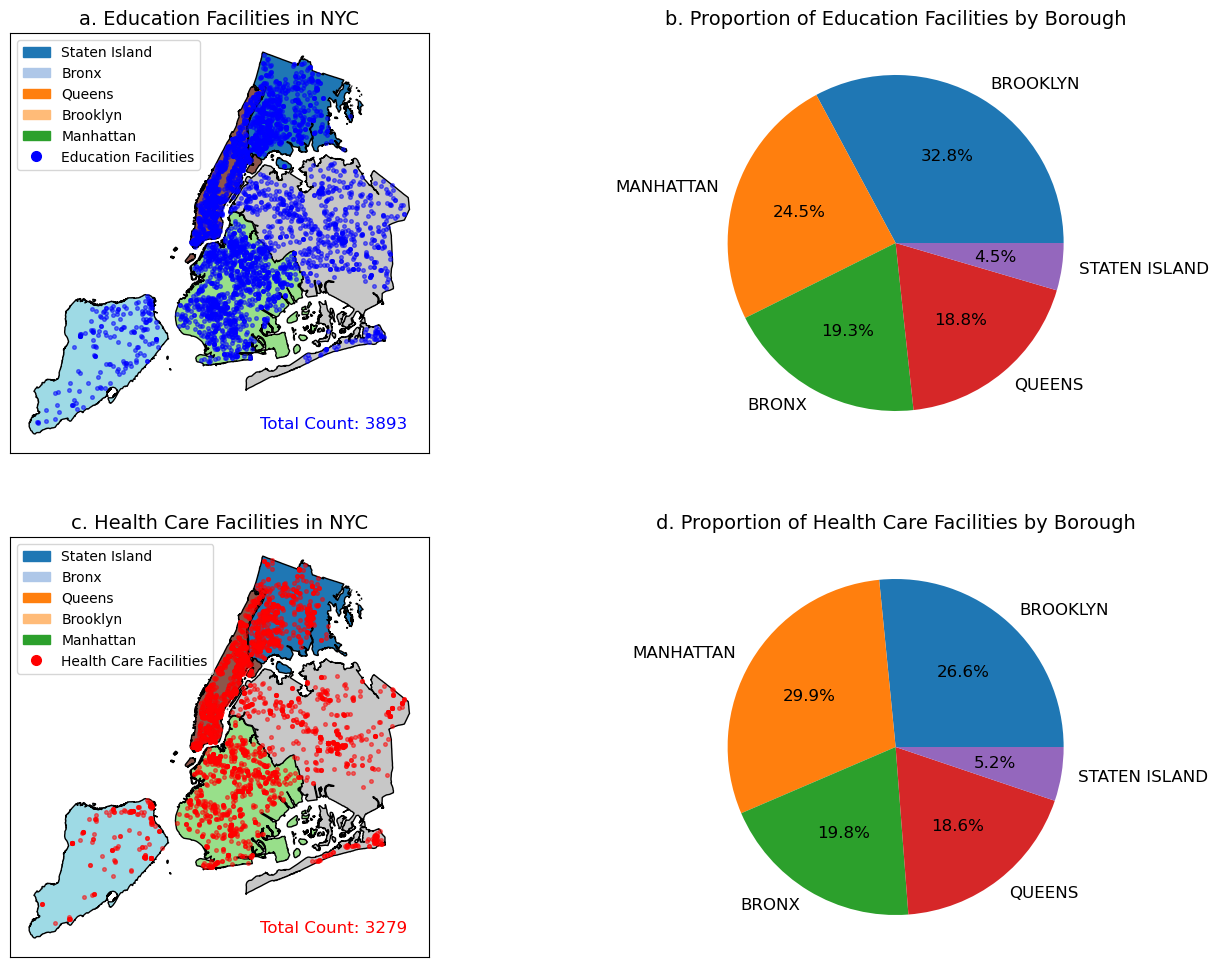

In [14]:
# Visualize the NYC POIs' Spatial and Numerical Information
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
education_poi = NYC_poi[NYC_poi['fac_type'] == 'Education']
health_care_poi = NYC_poi[NYC_poi['fac_type'] == 'Health Care']

# Fig a: Education Facilities' Spatial Distribution
NYC_borough.plot(ax=axs[0, 0], column='BoroName', cmap='tab20', edgecolor='black', legend=False)
education_poi.plot(ax=axs[0, 0], color='blue', alpha=0.5, markersize=7, label='Education Facilities')
axs[0, 0].set_title("a. Education Facilities in NYC", fontsize=14)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
education_count_total = len(education_poi)

# Add the total count of education facilities to the plot
axs[0, 0].text(
    0.95, 0.05, f"Total Count: {education_count_total}",
    transform=axs[0, 0].transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    color='blue',
    bbox=dict(facecolor='white', edgecolor='none')
)

# Legend for Fig a
borough_handles = [
    mpatches.Patch(color=color, label=name)
    for color, name in zip(
        plt.cm.tab20.colors[:len(NYC_borough['BoroName'].unique())],
        NYC_borough['BoroName'].unique()
    )
]
education_handle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=7, label='Education Facilities')
axs[0, 0].legend(handles=borough_handles + [education_handle], loc='upper left', fontsize=10, title_fontsize=12)

# Fig b: A Pie Chart of Education Facilities' Proportion by Borough
education_counts = education_poi['boro'].value_counts().reset_index()
education_counts.columns = ['boro', 'count']
axs[0, 1].pie(
    education_counts['count'],
    labels=education_counts['boro'],
    autopct='%1.1f%%',
    textprops={'fontsize': 12}
)
axs[0, 1].set_title("b. Proportion of Education Facilities by Borough", fontsize=14)

# Fig c: Health Care Facilities' Spatial Distribution
NYC_borough.plot(ax=axs[1, 0], column='BoroName', cmap='tab20', edgecolor='black', legend=False)
health_care_poi.plot(ax=axs[1, 0], color='red', alpha=0.5, markersize=7, label='Health Care Facilities')
axs[1, 0].set_title("c. Health Care Facilities in NYC", fontsize=14)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
health_care_count_total = len(health_care_poi)

# Add the total count of health care facilities to the plot
axs[1, 0].text(
    0.95, 0.05, f"Total Count: {health_care_count_total}",
    transform=axs[1, 0].transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    color='red',
    bbox=dict(facecolor='white', edgecolor='none')
)

# Legend for Fig c
health_care_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=7, label='Health Care Facilities')
axs[1, 0].legend(handles=borough_handles + [health_care_handle], loc='upper left', fontsize=10, title_fontsize=12)

# Fig d: A Pie Chart of Health Care Facilities' Proportion by Borough
health_care_counts = health_care_poi['boro'].value_counts().reset_index()
health_care_counts = health_care_counts.set_index('boro').reindex(education_counts['boro']).reset_index()
health_care_counts.columns = ['boro', 'count']
axs[1, 1].pie(
    health_care_counts['count'],
    labels=health_care_counts['boro'],
    autopct='%1.1f%%',
    textprops={'fontsize': 12}
)
axs[1, 1].set_title("d. Proportion of Health Care Facilities by Borough", fontsize=14)
plt.show()


<a id="2_4"></a>
### 2.4 Socio-economic Indicators from ACS

**(1) Preparations before acquiring the ACS data:**
- Make sure you have installed the ["census"](https://pypi.org/project/census/) and the ["us"](https://pypi.org/project/us/) Python packages in your environment
- Request a [U.S. Census Data API Key](https://api.census.gov/data/key_signup.html)
- Browse the [tables of ACS 5-Year data for the five boroughs of NYC](https://data.census.gov/table?q=United%20States&g=050XX00US36005$1400000,36047$1400000,36061$1400000,36081$1400000,36085$1400000&d=ACS%205-Year%20Estimates%20Detailed%20Tables) to better understand and choose the interested indicators.
- The indicators chosen for this project:

<table>
  <tr>
    <th>Code</th>
    <th>Name</th>
    <th>Original Table</th>
  </tr>
  <tr>
    <td>B02001_001E</td>
    <td>Total Population</td>
    <td rowspan="7"><a href="https://data.census.gov/table?q=B02001">B02001-Population by Race</a></td>
  </tr>
  <tr>
    <td>B02001_002E</td>
    <td>Population of White Race</td>
  </tr>
  <tr>
    <td>B02001_003E</td>
    <td>Population of Black or African American</td>
  </tr>
  <tr>
    <td>B02001_004E</td>
    <td>Population of American Indian and Alaska Native</td>
  </tr>
  <tr>
    <td>B02001_005E</td>
    <td>Population of Asian</td>
  </tr>
  <tr>
    <td>B02001_006E</td>
    <td>Population of Native Hawaiian and Other Pacific Islander</td>
  </tr>
  <tr>
    <td>B02001_007E</td>
    <td>Population of Some Other Races</td>
  </tr>
  <tr>
    <td>B17001_002E</td>
    <td>Population of Income in the past 12 months below poverty level</td>
    <td><a href="https://data.census.gov/table?q=B17001">B17001-Poverty Status in the Past 12 Months</a></td>
  </tr>
  <tr>
    <td>B06011_001E</td>
    <td>Annual Median Income</td>
    <td><a href="https://data.census.gov/table?q=B06011">B06011-Median Income in the Past 12 Months</a></td>
  </tr>
</table>


**(2) Acquiring and pre-processing the ACS data:**
- ***Step 1:*** Make API calls to extract interested data
- ***Step 2:*** Convert extracted data into pandas DataFrame format
- ***Step 3:*** Left-join the ACS indicators to the **NYC_census_tract** GeoDataFrame by the mutual **"GEOID"** field
- ***Step 4:*** Check missing or abnormal values for all indicators after joining
- ***Step 5:*** Select necessary columns from **NYC_census_tract**, rename the columns, and re-group the population data before visualization
- `NOTE`: In case you don't have an API key, you can use mine: c749e019b8b8dcd18a1a93b9c616c0751b78d8eb

In [15]:
# Please enter your API key
# NOTE: In case you don't have one, you can use mine: c749e019b8b8dcd18a1a93b9c616c0751b78d8eb
API_key = getpass("Enter your API Key: ")
c = Census(API_key)

# Obtain Census variables from the 2022 ACS at the tract level for the NYC
# API call sources: https://api.census.gov/data/2022/acs/acs5/variables.html
ny_ACS = c.acs5.state_county_tract(fields = ('NAME', 'B02001_001E', 'B02001_002E','B02001_003E','B02001_004E','B02001_005E', 'B02001_006E', 'B02001_007E', 'B17001_002E', 'B06011_001E'),
                                      state_fips = states.NY.fips, # New York State FIPS code
                                      county_fips = "*", # All counties in New York State
                                      tract = "*", # All census tracts in New York State
                                      year = 2022)  # 2022 ACS data

# Create a dataframe storing the ACS data
ny_ACS = pd.DataFrame(ny_ACS)

display(ny_ACS.head())
print('Shape: ', ny_ACS.shape)

NAME  B02001_001E  B02001_002E  \
0     Census Tract 1; Albany County; New York       2259.0        750.0   
1  Census Tract 2.01; Albany County; New York       2465.0        388.0   
2  Census Tract 2.02; Albany County; New York       2374.0        317.0   
3  Census Tract 3.01; Albany County; New York       2837.0       1005.0   
4  Census Tract 3.02; Albany County; New York       3200.0       2039.0   

   B02001_003E  B02001_004E  B02001_005E  B02001_006E  B02001_007E  \
0        989.0          0.0         30.0         20.0        280.0   
1       1777.0          0.0        102.0          0.0         23.0   
2       1979.0          0.0          0.0          0.0          4.0   
3       1271.0          0.0          4.0          0.0        236.0   
4        565.0          7.0        139.0          0.0         45.0   

   B17001_002E  B06011_001E state county   tract  
0        641.0      22687.0    36    001  000100  
1        754.0      21033.0    36    001  000201  
2        768.0      26319.0    36    001  000202  
3        921.0      29654.0    36    001  000301  
4        638.0      38669.0    36    001  000302

Shape:  (5411, 13)


In [16]:
# Create a GEOID column: state + county + tract
ny_ACS["GEOID"] = ny_ACS["state"] + ny_ACS["county"] + ny_ACS["tract"]

# Make sure the GEOID attribute is a string for both datasets (ny_ACS and NYC_census_tract) for merging
ny_ACS["GEOID"] = ny_ACS["GEOID"].astype(str)
NYC_census_tract["geoid"] = NYC_census_tract["geoid"].astype(str)

# Left join the ACS data to the NYC census tract data based on the GEOID
NYC_census_tract = NYC_census_tract.merge(ny_ACS, left_on="geoid", right_on="GEOID", how="left")
display(NYC_census_tract.head())
print('Shape: ', NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   

                                            geometry  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...   

                                            NAME  B02001_001E  B02001_002E  \
0      Census Tract 1; New York County; New York          0.0          0.0   
1  Census Tract 14.01; New York County; New York       3165.0       2260.0   
2  Census Tract 14.02; New York County; New York       3286.0       1150.0   
3     Census Tract 18; New York County; New York       6948.0       2619.0   
4  Census Tract 22.01; New York County; New York       6748.0       2173.0   

   B02001_003E  B02001_004E  B02001_005E  B02001_006E  B02001_007E  \
0          0.0          0.0          0.0          0.0          0.0   
1         96.0          0.0        251.0         24.0        195.0   
2        250.0         10.0       1099.0          0.0        514.0   
3        405.0         42.0       3171.0          0.0        287.0   
4       1327.0         23.0        880.0          0.0       2056.0   

   B17001_002E  B06011_001E state county   tract        GEOID  
0          0.0 -666666666.0    36    061  000100  36061000100  
1        162.0      46837.0    36    061  001401  36061001401  
2        946.0      44000.0    36    061  001402  36061001402  
3        873.0      37075.0    36    061  001800  36061001800  
4       1849.0      30033.0    36    061  002201  36061002201

Shape:  (2325, 18)


In [17]:
# Check for missing or abnormal values
columns_to_check = [
    "B02001_001E",
    "B02001_002E",
    "B02001_003E",
    "B02001_004E",
    "B02001_005E",
    "B02001_006E",
    "B02001_007E",
    "B17001_002E",
    "B06011_001E"
]

# Replace missing values with 0
NYC_census_tract[columns_to_check] = NYC_census_tract[columns_to_check].applymap(lambda x: max(x, 0))

# Drop unnecessary columns
NYC_census_tract.drop(columns=["NAME", 'state', 'county', 'tract'], inplace=True)

# Rename the columns with more meaningful names
NYC_census_tract.rename(columns={"B02001_001E": "Total Population", "B02001_002E": "White Population",
                                 "B02001_003E": "Black Population", "B02001_004E": "American Indian and Alaska Native Population",
                                 "B02001_005E": "Asian Population", "B02001_006E": "Native Hawaiian and Other Pacific Islander Population",
                                 "B02001_007E": "Other Races Population",
                                 "B17001_002E": "Poverty Population", "B06011_001E": "Median Income (USD)"}, inplace=True)

# Grouping of Native Hawaiian and Other Pacific Islander and American Indian and Alaska Native into Other Races for simplicity
NYC_census_tract["Other Races Population"] = NYC_census_tract["Other Races Population"]+NYC_census_tract["Native Hawaiian and Other Pacific Islander Population"]+NYC_census_tract["American Indian and Alaska Native Population"]


# Select the necessary columns again
NYC_census_tract = NYC_census_tract.drop(columns=["American Indian and Alaska Native Population", "Native Hawaiian and Other Pacific Islander Population", "GEOID"])
display(NYC_census_tract.head(10))
print("shape:", NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   
5        1  Manhattan  36061002601   
6        1  Manhattan  36061002602   
7        1  Manhattan  36061002800   
8        1  Manhattan  36061003100   
9        1  Manhattan  36061003200   

                                            geometry  Total Population  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...               0.0   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...            3165.0   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...            3286.0   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...            6948.0   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...            6748.0   
5  MULTIPOLYGON (((586405.487 4508455.689, 586373...            4592.0   
6  MULTIPOLYGON (((586512.887 4508655.259, 586485...            3632.0   
7  MULTIPOLYGON (((586702.647 4509006.581, 586661...            6364.0   
8  MULTIPOLYGON (((584298.712 4508087.314, 584339...            2667.0   
9  MULTIPOLYGON (((586145.288 4508937.665, 586123...            7523.0   

   White Population  Black Population  Asian Population  \
0               0.0               0.0               0.0   
1            2260.0              96.0             251.0   
2            1150.0             250.0            1099.0   
3            2619.0             405.0            3171.0   
4            2173.0            1327.0             880.0   
5            1441.0             734.0             758.0   
6            2219.0             289.0             392.0   
7            2433.0             338.0            1357.0   
8            1299.0             312.0             704.0   
9            5999.0             207.0             581.0   

   Other Races Population  Poverty Population  Median Income (USD)  
0                     0.0                 0.0                  0.0  
1                   219.0               162.0              46837.0  
2                   524.0               946.0              44000.0  
3                   329.0               873.0              37075.0  
4                  2079.0              1849.0              30033.0  
5                   861.0              1597.0              19983.0  
6                   398.0               625.0              51757.0  
7                  1031.0              1527.0              37852.0  
8                   125.0               198.0              23647.0  
9                   521.0              1308.0              70353.0

shape: (2325, 11)


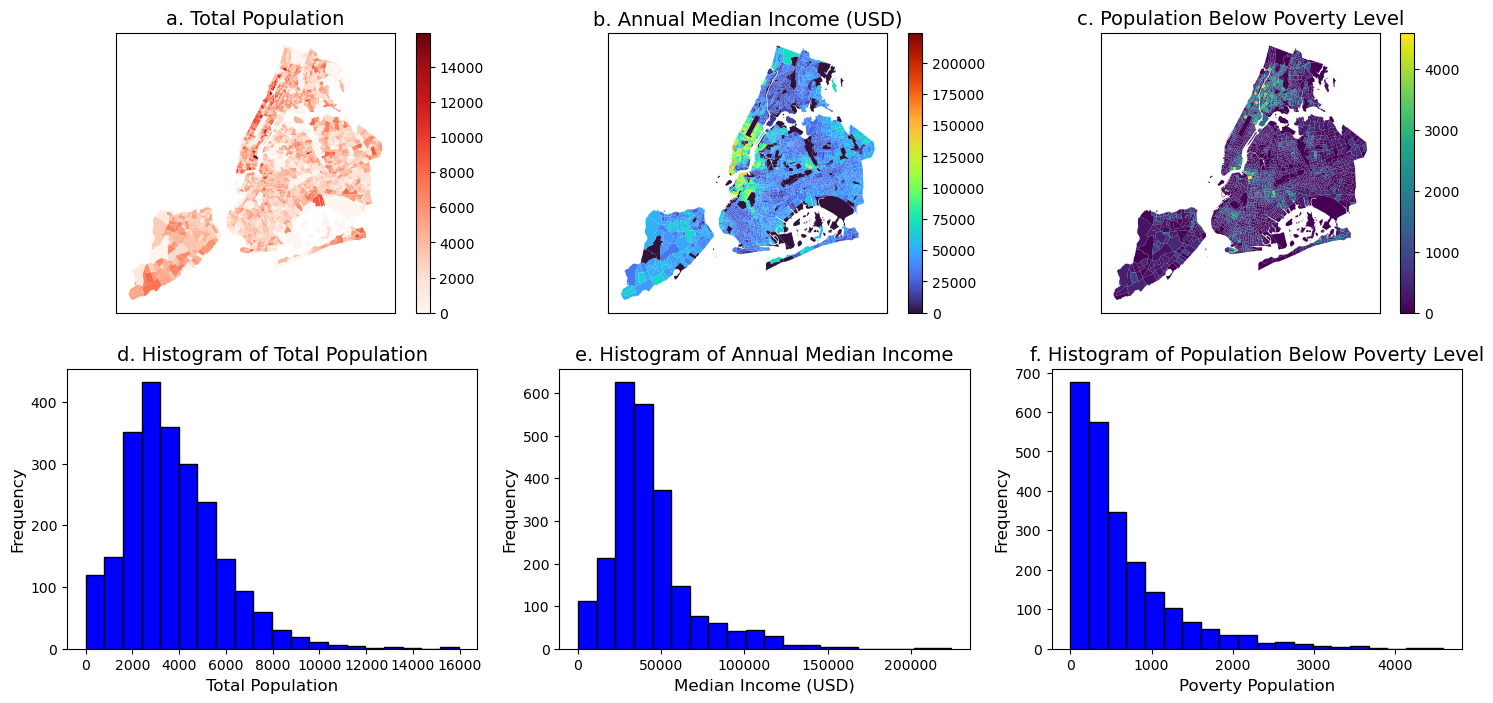

In [18]:
# Visualize the NYC Census Tracts Data with Partial ACS Information
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Fig a. Total Population
NYC_census_tract.plot(column='Total Population', legend=True, ax=axs[0, 0], cmap='Reds')
axs[0, 0].set_title("a. Total Population", fontsize=14)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
legend = axs[0, 0].get_legend()

# Fig b. Median Income
NYC_census_tract.plot(column='Median Income (USD)', legend=True, ax=axs[0, 1], cmap='turbo')
axs[0, 1].set_title("b. Annual Median Income (USD)", fontsize=14)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
legend = axs[0, 1].get_legend()

# Fig c. Poverty Population
NYC_census_tract.plot(column='Poverty Population', legend=True, ax=axs[0, 2], cmap='viridis')
axs[0, 2].set_title("c. Population Below Poverty Level", fontsize=14)
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
legend = axs[0, 2].get_legend()

# Fig d. Histogram of Total Population
NYC_census_tract['Total Population'].plot.hist(ax=axs[1, 0], bins=20, color='blue', edgecolor='black')
axs[1, 0].set_title("d. Histogram of Total Population", fontsize=14)
axs[1, 0].set_xlabel("Total Population", fontsize=12)
axs[1, 0].set_ylabel("Frequency", fontsize=12)

# Fig e. Histogram of Median Income
NYC_census_tract['Median Income (USD)'].plot.hist(ax=axs[1, 1], bins=20, color='blue', edgecolor='black')
axs[1, 1].set_title("e. Histogram of Annual Median Income", fontsize=14)
axs[1, 1].set_xlabel("Median Income (USD)", fontsize=12)
axs[1, 1].set_ylabel("Frequency", fontsize=12)

# Fig f. Histogram of Poverty Population
NYC_census_tract['Poverty Population'].plot.hist(ax=axs[1, 2], bins=20, color='blue', edgecolor='black')
axs[1, 2].set_title("f. Histogram of Population Below Poverty Level", fontsize=14)
axs[1, 2].set_xlabel("Poverty Population", fontsize=12)
axs[1, 2].set_ylabel("Frequency", fontsize=12)
plt.show()

<a id="2_5"></a>
### 2.5 Other Indicators Generated by Current Acquired Data

**(1) Road Density**
- ***Step 1:*** Compute the area of each census tract in the NYC_census_tract dataset
- ***Step 2:*** Spatial join the **NYC_road** with the **NYC_census_tract** to identify road segments intersecting each census tract
- ***Step 3:*** Calculate the length of road segments that intersect with each census tract
- ***Step 4:*** Sum the total lengths of intersecting road segments for each census tract, grouped by GEOID
- ***Step 5:*** For each census tract (GEOID), divide the total road length by the area to determine the road density (total road length per unit area)

In [19]:
# Compute the area of each census tract in km2
NYC_census_tract['area_km2'] = NYC_census_tract.geometry.area / 1000000

# Spatial Join of the NYC Roads and the NYC Census Tracts
road_intersections = gpd.sjoin(NYC_road, NYC_census_tract, how='inner', predicate='intersects')

# Compute the length of each intersected road segment in km
road_intersections['road_length_km'] = road_intersections.geometry.length / 1000

# Compute the total road length and road density for each census tract
road_density = road_intersections.groupby('geoid')['road_length_km'].sum().reset_index()
road_density.rename(columns={'road_length_km': 'total_road_length_km'}, inplace=True)

# Merge the road density information to the NYC census tract data
NYC_census_tract = NYC_census_tract.merge(road_density, on='geoid', how='left')
NYC_census_tract['Road Density'] = NYC_census_tract['total_road_length_km'] / NYC_census_tract['area_km2']

# Replace missing values with 0
NYC_census_tract['Road Density'].fillna(0, inplace=True)

# Drop unnecessary columns
NYC_census_tract.drop(columns=['total_road_length_km'], inplace=True)

display(NYC_census_tract.head(10))
print("shape:", NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   
5        1  Manhattan  36061002601   
6        1  Manhattan  36061002602   
7        1  Manhattan  36061002800   
8        1  Manhattan  36061003100   
9        1  Manhattan  36061003200   

                                            geometry  Total Population  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...               0.0   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...            3165.0   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...            3286.0   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...            6948.0   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...            6748.0   
5  MULTIPOLYGON (((586405.487 4508455.689, 586373...            4592.0   
6  MULTIPOLYGON (((586512.887 4508655.259, 586485...            3632.0   
7  MULTIPOLYGON (((586702.647 4509006.581, 586661...            6364.0   
8  MULTIPOLYGON (((584298.712 4508087.314, 584339...            2667.0   
9  MULTIPOLYGON (((586145.288 4508937.665, 586123...            7523.0   

   White Population  Black Population  Asian Population  \
0               0.0               0.0               0.0   
1            2260.0              96.0             251.0   
2            1150.0             250.0            1099.0   
3            2619.0             405.0            3171.0   
4            2173.0            1327.0             880.0   
5            1441.0             734.0             758.0   
6            2219.0             289.0             392.0   
7            2433.0             338.0            1357.0   
8            1299.0             312.0             704.0   
9            5999.0             207.0             581.0   

   Other Races Population  Poverty Population  Median Income (USD)  area_km2  \
0                     0.0                 0.0                  0.0  0.171110   
1                   219.0               162.0              46837.0  0.093414   
2                   524.0               946.0              44000.0  0.113849   
3                   329.0               873.0              37075.0  0.222764   
4                  2079.0              1849.0              30033.0  0.161569   
5                   861.0              1597.0              19983.0  0.105958   
6                   398.0               625.0              51757.0  0.103511   
7                  1031.0              1527.0              37852.0  0.183250   
8                   125.0               198.0              23647.0  0.204913   
9                   521.0              1308.0              70353.0  0.216845   

   Road Density  
0      0.000000  
1     25.657053  
2     36.129644  
3     35.818790  
4     19.262698  
5     27.027766  
6     22.864433  
7     22.576522  
8     17.437293  
9     19.764479

shape: (2325, 13)


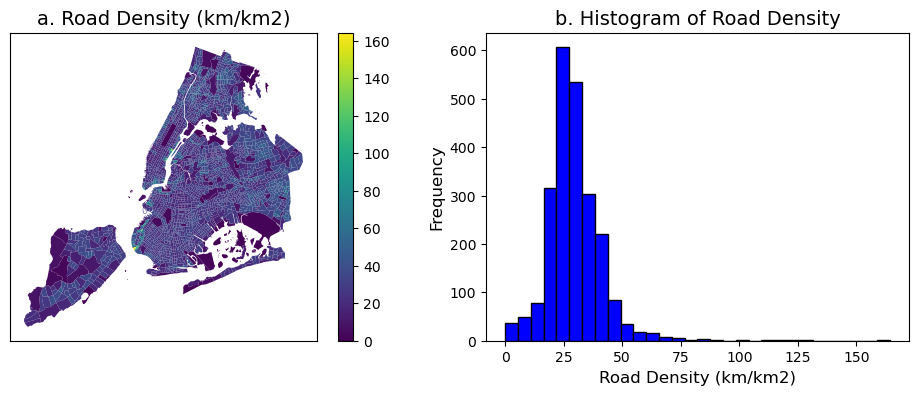

In [20]:
# Visualize the NYC Census Tracts Data with Road Density Information
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Fig a. Road Density
NYC_census_tract.plot(column='Road Density', legend=True, ax=axs[0], cmap='viridis')
axs[0].set_title("a. Road Density (km/km2)", fontsize=14)
axs[0].set_xticks([])
axs[0].set_yticks([])
legend = axs[0].get_legend()

# Fig b. Histogram of Road Density
NYC_census_tract['Road Density'].plot.hist(ax=axs[1], bins=30, color='blue', edgecolor='black')
axs[1].set_title("b. Histogram of Road Density", fontsize=14)
axs[1].set_xlabel("Road Density (km/km2)", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
plt.show()

**(2) Facility Density**
- Including Density of Education Facilities and Health Care Facilities
- Formula: 
  - Facility Density = Number of Facilities / Area of the current census tract (Number of facilities per area unit)
- Similar procedures as the road density calculations

In [21]:
# Extract the education and health care facilities from the NYC POI data
NYC_education_poi = NYC_poi[NYC_poi["fac_type"] == "Education"]
NYC_health_poi = NYC_poi[NYC_poi["fac_type"] == "Health Care"]

# 1. Education Facility Density
points_within_area = gpd.sjoin(NYC_education_poi, NYC_census_tract, how="inner", predicate="within")
points_count_by_area = points_within_area.groupby("geoid").size().reset_index(name="point_count_edu")
NYC_census_tract = NYC_census_tract.merge(points_count_by_area, on="geoid", how="left")
NYC_census_tract["Education Facility Density"] = NYC_census_tract["point_count_edu"].fillna(0).astype(int)

# 2. Health Care Facility Density
points_within_area = gpd.sjoin(NYC_health_poi, NYC_census_tract, how="inner", predicate="within")
points_count_by_area = points_within_area.groupby("geoid").size().reset_index(name="point_count_health")
NYC_census_tract = NYC_census_tract.merge(points_count_by_area, on="geoid", how="left")
NYC_census_tract["Health Care Facility Density"] = NYC_census_tract["point_count_health"].fillna(0).astype(int)

# Replace missing values with 0
NYC_census_tract["Education Facility Density"].fillna(0, inplace=True)

# Drop unnecessary columns
NYC_census_tract.drop(columns=["point_count_edu", "point_count_health"], inplace=True)

display(NYC_census_tract.head(10))
print("shape:", NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   
5        1  Manhattan  36061002601   
6        1  Manhattan  36061002602   
7        1  Manhattan  36061002800   
8        1  Manhattan  36061003100   
9        1  Manhattan  36061003200   

                                            geometry  Total Population  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...               0.0   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...            3165.0   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...            3286.0   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...            6948.0   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...            6748.0   
5  MULTIPOLYGON (((586405.487 4508455.689, 586373...            4592.0   
6  MULTIPOLYGON (((586512.887 4508655.259, 586485...            3632.0   
7  MULTIPOLYGON (((586702.647 4509006.581, 586661...            6364.0   
8  MULTIPOLYGON (((584298.712 4508087.314, 584339...            2667.0   
9  MULTIPOLYGON (((586145.288 4508937.665, 586123...            7523.0   

   White Population  Black Population  Asian Population  \
0               0.0               0.0               0.0   
1            2260.0              96.0             251.0   
2            1150.0             250.0            1099.0   
3            2619.0             405.0            3171.0   
4            2173.0            1327.0             880.0   
5            1441.0             734.0             758.0   
6            2219.0             289.0             392.0   
7            2433.0             338.0            1357.0   
8            1299.0             312.0             704.0   
9            5999.0             207.0             581.0   

   Other Races Population  Poverty Population  Median Income (USD)  area_km2  \
0                     0.0                 0.0                  0.0  0.171110   
1                   219.0               162.0              46837.0  0.093414   
2                   524.0               946.0              44000.0  0.113849   
3                   329.0               873.0              37075.0  0.222764   
4                  2079.0              1849.0              30033.0  0.161569   
5                   861.0              1597.0              19983.0  0.105958   
6                   398.0               625.0              51757.0  0.103511   
7                  1031.0              1527.0              37852.0  0.183250   
8                   125.0               198.0              23647.0  0.204913   
9                   521.0              1308.0              70353.0  0.216845   

   Road Density  Education Facility Density  Health Care Facility Density  
0      0.000000                           0                             0  
1     25.657053                           0                             7  
2     36.129644                           2                             1  
3     35.818790                           5                            13  
4     19.262698                           4                             0  
5     27.027766                           4                             2  
6     22.864433                           0                             1  
7     22.576522                           2                             1  
8     17.437293                           0                             5  
9     19.764479                           5                             0

shape: (2325, 15)


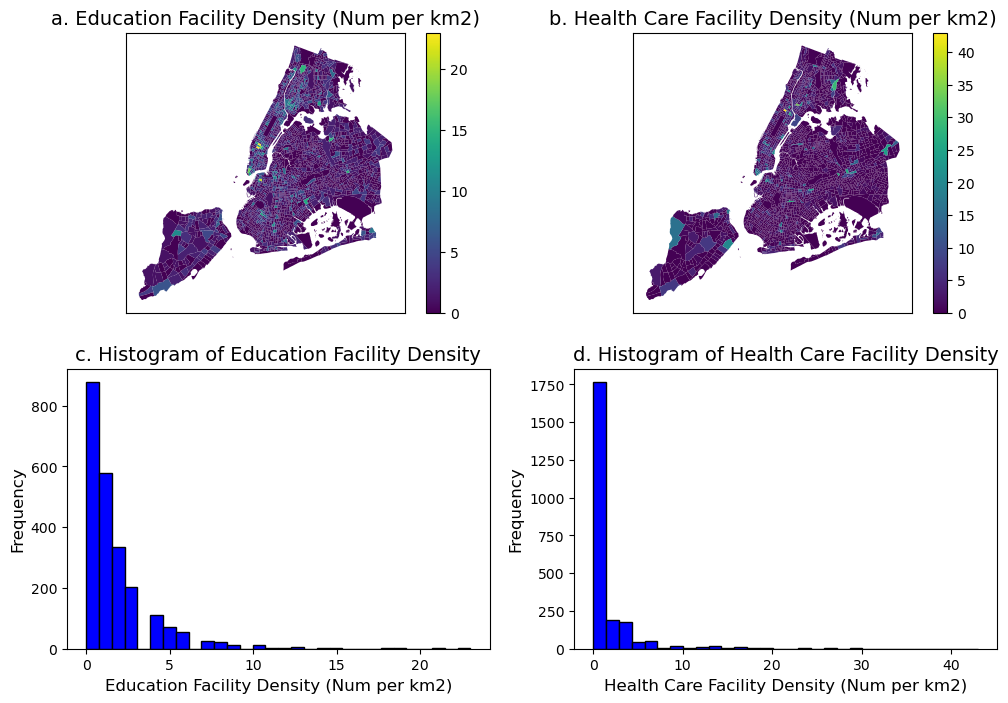

In [22]:
# Visualize the NYC Census Tracts Data with Facility Density Information
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Fig a. Education Facility Density
NYC_census_tract.plot(column='Education Facility Density', legend=True, ax=axs[0, 0], cmap='viridis')
axs[0, 0].set_title("a. Education Facility Density (Num per km2)", fontsize=14)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
legend = axs[0, 0].get_legend()

# Fig b. Health Care Facility Density
NYC_census_tract.plot(column='Health Care Facility Density', legend=True, ax=axs[0, 1], cmap='viridis')
axs[0, 1].set_title("b. Health Care Facility Density (Num per km2)", fontsize=14)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
legend = axs[0, 1].get_legend()

# Fig c. Histogram of Education Facility Density
NYC_census_tract['Education Facility Density'].plot.hist(ax=axs[1, 0], bins=30, color='blue', edgecolor='black')
axs[1, 0].set_title("c. Histogram of Education Facility Density", fontsize=14)
axs[1, 0].set_xlabel("Education Facility Density (Num per km2)", fontsize=12)
axs[1, 0].set_ylabel("Frequency", fontsize=12)

# Fig d. Histogram of Health Care Facility Density
NYC_census_tract['Health Care Facility Density'].plot.hist(ax=axs[1, 1], bins=30, color='blue', edgecolor='black')
axs[1, 1].set_title("d. Histogram of Health Care Facility Density", fontsize=14)
axs[1, 1].set_xlabel("Health Care Facility Density (Num per km2)", fontsize=12)
axs[1, 1].set_ylabel("Frequency", fontsize=12)
plt.show()

**(3) Poverty Ratio**
- Formula: Poverty Ratio = Poverty Population/Total Population

In [23]:
NYC_census_tract['Poverty Ratio'] = NYC_census_tract['Poverty Population'] / (NYC_census_tract['Total Population']+0.0001)
display(NYC_census_tract.head(10))
print("shape:", NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   
5        1  Manhattan  36061002601   
6        1  Manhattan  36061002602   
7        1  Manhattan  36061002800   
8        1  Manhattan  36061003100   
9        1  Manhattan  36061003200   

                                            geometry  Total Population  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...               0.0   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...            3165.0   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...            3286.0   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...            6948.0   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...            6748.0   
5  MULTIPOLYGON (((586405.487 4508455.689, 586373...            4592.0   
6  MULTIPOLYGON (((586512.887 4508655.259, 586485...            3632.0   
7  MULTIPOLYGON (((586702.647 4509006.581, 586661...            6364.0   
8  MULTIPOLYGON (((584298.712 4508087.314, 584339...            2667.0   
9  MULTIPOLYGON (((586145.288 4508937.665, 586123...            7523.0   

   White Population  Black Population  Asian Population  \
0               0.0               0.0               0.0   
1            2260.0              96.0             251.0   
2            1150.0             250.0            1099.0   
3            2619.0             405.0            3171.0   
4            2173.0            1327.0             880.0   
5            1441.0             734.0             758.0   
6            2219.0             289.0             392.0   
7            2433.0             338.0            1357.0   
8            1299.0             312.0             704.0   
9            5999.0             207.0             581.0   

   Other Races Population  Poverty Population  Median Income (USD)  area_km2  \
0                     0.0                 0.0                  0.0  0.171110   
1                   219.0               162.0              46837.0  0.093414   
2                   524.0               946.0              44000.0  0.113849   
3                   329.0               873.0              37075.0  0.222764   
4                  2079.0              1849.0              30033.0  0.161569   
5                   861.0              1597.0              19983.0  0.105958   
6                   398.0               625.0              51757.0  0.103511   
7                  1031.0              1527.0              37852.0  0.183250   
8                   125.0               198.0              23647.0  0.204913   
9                   521.0              1308.0              70353.0  0.216845   

   Road Density  Education Facility Density  Health Care Facility Density  \
0      0.000000                           0                             0   
1     25.657053                           0                             7   
2     36.129644                           2                             1   
3     35.818790                           5                            13   
4     19.262698                           4                             0   
5     27.027766                           4                             2   
6     22.864433                           0                             1   
7     22.576522                           2                             1   
8     17.437293                           0                             5   
9     19.764479                           5                             0   

   Poverty Ratio  
0       0.000000  
1       0.051185  
2       0.287888  
3       0.125648  
4       0.274007  
5       0.347779  
6       0.172081  
7       0.239943  
8       0.074241  
9       0.173867

shape: (2325, 16)


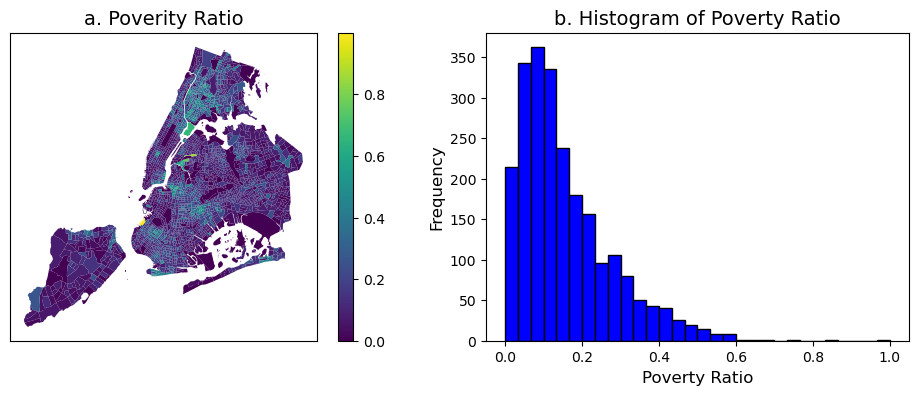

In [24]:
# Visualize the NYC Census Tracts Data with Facility Density Information
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Fig a. Poverity Ratio
NYC_census_tract.plot(column='Poverty Ratio', legend=True, ax=axs[0], cmap='viridis')
axs[0].set_title("a. Poverity Ratio", fontsize=14)
axs[0].set_xticks([])
axs[0].set_yticks([])
legend = axs[0].get_legend()

# Fig b. Histogram of Poverity Ratio
NYC_census_tract['Poverty Ratio'].plot.hist(ax=axs[1], bins=30, color='blue', edgecolor='black')
axs[1].set_title("b. Histogram of Poverty Ratio", fontsize=14)
axs[1].set_xlabel("Poverty Ratio", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
plt.show()

**(4) Population Density**:
- Formula: Population Density = Total Population/Area of the census tract (number of people per area unit)

In [25]:
# Calculate the Population Density
NYC_census_tract['Population Density'] = NYC_census_tract['Total Population'] / NYC_census_tract['area_km2']
display(NYC_census_tract.head(10))
print("shape:", NYC_census_tract.shape)

borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   
5        1  Manhattan  36061002601   
6        1  Manhattan  36061002602   
7        1  Manhattan  36061002800   
8        1  Manhattan  36061003100   
9        1  Manhattan  36061003200   

                                            geometry  Total Population  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...               0.0   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...            3165.0   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...            3286.0   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...            6948.0   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...            6748.0   
5  MULTIPOLYGON (((586405.487 4508455.689, 586373...            4592.0   
6  MULTIPOLYGON (((586512.887 4508655.259, 586485...            3632.0   
7  MULTIPOLYGON (((586702.647 4509006.581, 586661...            6364.0   
8  MULTIPOLYGON (((584298.712 4508087.314, 584339...            2667.0   
9  MULTIPOLYGON (((586145.288 4508937.665, 586123...            7523.0   

   White Population  Black Population  Asian Population  \
0               0.0               0.0               0.0   
1            2260.0              96.0             251.0   
2            1150.0             250.0            1099.0   
3            2619.0             405.0            3171.0   
4            2173.0            1327.0             880.0   
5            1441.0             734.0             758.0   
6            2219.0             289.0             392.0   
7            2433.0             338.0            1357.0   
8            1299.0             312.0             704.0   
9            5999.0             207.0             581.0   

   Other Races Population  Poverty Population  Median Income (USD)  area_km2  \
0                     0.0                 0.0                  0.0  0.171110   
1                   219.0               162.0              46837.0  0.093414   
2                   524.0               946.0              44000.0  0.113849   
3                   329.0               873.0              37075.0  0.222764   
4                  2079.0              1849.0              30033.0  0.161569   
5                   861.0              1597.0              19983.0  0.105958   
6                   398.0               625.0              51757.0  0.103511   
7                  1031.0              1527.0              37852.0  0.183250   
8                   125.0               198.0              23647.0  0.204913   
9                   521.0              1308.0              70353.0  0.216845   

   Road Density  Education Facility Density  Health Care Facility Density  \
0      0.000000                           0                             0   
1     25.657053                           0                             7   
2     36.129644                           2                             1   
3     35.818790                           5                            13   
4     19.262698                           4                             0   
5     27.027766                           4                             2   
6     22.864433                           0                             1   
7     22.576522                           2                             1   
8     17.437293                           0                             5   
9     19.764479                           5                             0   

   Poverty Ratio  Population Density  
0       0.000000            0.000000  
1       0.051185        33881.370808  
2       0.287888        28862.855952  
3       0.125648        31190.003758  
4       0.274007        41765.435762  
5       0.347779        43337.875978  
6       0.172081        35088.156724  
7       0.239943        34728.604538  
8       0.074241        13015.263648  

shape: (2325, 17)


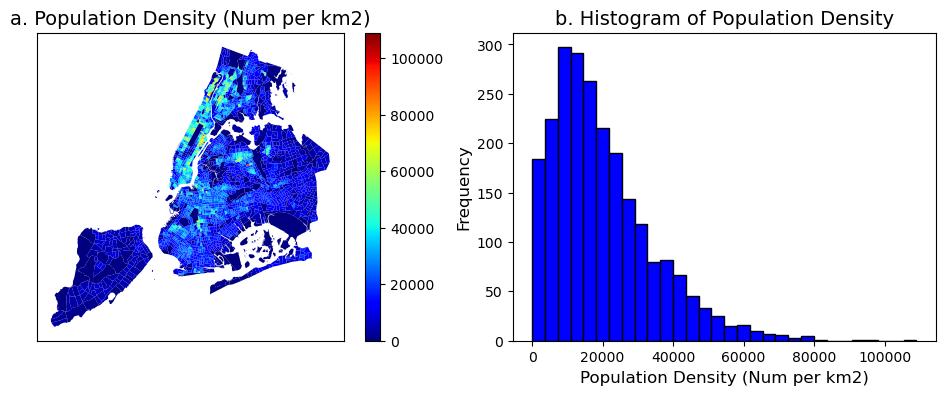

In [26]:
# Visualize the NYC Census Tracts Data with Population Density Information
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Fig a. Population Density
NYC_census_tract.plot(column='Population Density', legend=True, ax=axs[0], cmap='jet')
axs[0].set_title("a. Population Density (Num per km2)", fontsize=14)
axs[0].set_xticks([])
axs[0].set_yticks([])
legend = axs[0].get_legend()

# Fig b. Histogram of Population Density
NYC_census_tract['Population Density'].plot.hist(ax=axs[1], bins=30, color='blue', edgecolor='black')
axs[1].set_title("b. Histogram of Population Density", fontsize=14)
axs[1].set_xlabel("Population Density (Num per km2)", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
plt.show()

<a id="3"></a>
## **3. Data Visualization and Analysis**


<a id="3_1"></a>
### 3.1 Spatial Accessibility Distribution of Different Public Facilities

**(1) Accessibility Measurements: Gaussia-Decay-Based Two-Step Floating Catchment Area (2FSCA)**

*Radke and Mu (2000)* first proposed 2SFCA to calculate the spatial accessibility of demand points by computing the supply-demand ratio based on supply and demand points.To address the limitations of the traditional 2SFCA, this study incorporates a Gaussian-decay weighting function to better simulate the influence of distance on service accessibility. The Gaussian-decay function assigns weights that decrease with increasing distance, which more realistically reflects the boundary effects of service coverage, especially when analyzing urban areas .

The Gaussian decay function is expressed as:

$$
W(d) = e^{-\frac{d^2}{2\sigma^2}}
$$

Where:
- $W(d)$: Distance decay weight, indicating the reduction in weight as distance $ d$ increases.
- $d$: The distance between the facility and the demand point.
- $\sigma$: Standard deviation of the Gaussian function, controlling the decay rate. Smaller $\sigma$ values result in faster weight decay, while larger $\sigma$ values indicate slower decay.

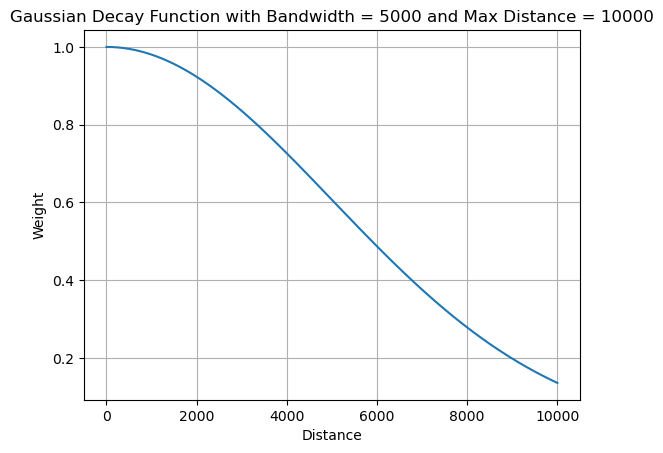

In [27]:
def gaussian_decay(distance, bandwidth):
    """
    Gaussian Decay Function: Calculate the weight based on distance and bandwidth.
    """
    return np.exp(- (distance**2) / (2 * bandwidth**2))

# Set parameters
bandwidth = 5000  # Gaussian decay bandwidth, unit: meter.
max_distance = 10000  # Maximum distance, unit: meter
distances = np.linspace(0, max_distance, 400)
weights = gaussian_decay(distances, bandwidth)

plt.plot(distances, weights)
plt.title('Gaussian Decay Function with Bandwidth = 5000 and Max Distance = 10000')
plt.xlabel('Distance')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

Specifically, the Gaussian-decay-based 2SFCA model consists of the following two steps:

***Step 1:***

For each facility $j$, calculate the resource allocation factor $ R_j $ as follows ( *Liu et al., 2023* ):

$$
R_j = \frac{S_j}{\sum_{i \in D(d \leq d_0)} W(d_{ij}) \cdot P_i}
$$

Where:
- $R_j$: The resource allocation factor for facility $j$.
- $S_j$: The total service capacity of facility $j$.
- $P_i$: The population of demand point $i$.
- $W(d_{ij})$: The Gaussian-decay weight for the distance between facility $j$ and demand point $i$.
- $d_0$: The maximum service radius, where only distances $ d \leq d_0 $ are considered.
- $D(d \leq d_0)$: The set of all demand points within the maximum service radius.

***Step 2:***

For each demand point $i$, calculate the accessibility index ($A_i$) as follows:

$$
A_i = \sum_{j \in S(d \leq d_0)} W(d_{ij}) \cdot R_j
$$

Where:
- $A_i$: The accessibility index for demand point $i$.
- $R_j$: The resource allocation factor for facility $j$.
- $W(d_{ij})$: The Gaussian-decay weight for the distance between demand point $i$ and facility $j$.
- $S(d \leq d_0)$: The set of all facilities within the maximum service radius.

By incorporating the Gaussian decay function, this model allows for a more realistic representation of the impact of distance on service accessibility. This approach is particularly effective for urban accessibility analysis, as it accounts for the gradual decay of service influence over distance while respecting the boundaries of service coverage. 

<Figure size 1000x800 with 0 Axes>

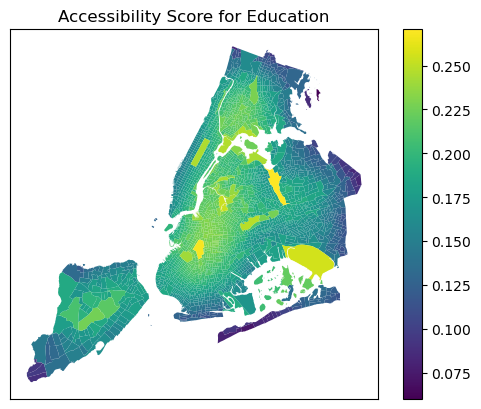

<Figure size 1000x800 with 0 Axes>

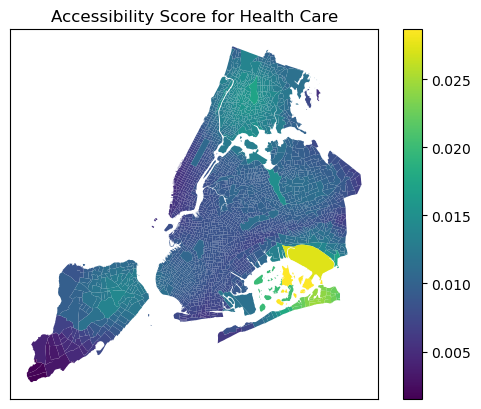

In [28]:
# initialization
NYC_poi['capacity'] = pd.to_numeric(NYC_poi['capacity'], errors='coerce')
facility_types = ['Education','Health Care']  # get the name of each facilities
accessibility_columns = [] 

# Calculate the average capacity grouped by `boro` and `fac_type`
boro_fac_type_avg_capacity = (
    NYC_poi.groupby(['boro', 'fac_type'], dropna=False)['capacity']
    .mean()  
    .reset_index()
)
boro_fac_type_avg_capacity.rename(columns={'capacity': 'avg_capacity'}, inplace=True)

# Calculate accessibility scores by facility type
for fac_type in facility_types:
    # select current facility type
    poi_subset = NYC_poi[NYC_poi['fac_type'] == fac_type]
    poi_subset['access_score'] = 0
    
    # calculate score
    for idx, facility in poi_subset.iterrows():
        distances = NYC_census_tract.geometry.distance(facility.geometry)
        within_range = distances <= max_distance
        weights = gaussian_decay(distances[within_range], bandwidth)
        weighted_population = (NYC_census_tract.loc[within_range, 'Total Population'] * weights).sum()
        
        # Replace cases where capacity is 0 or missing.
        capacity = facility['capacity']
        if capacity <= 0 or np.isnan(capacity):  # if capacity is 0 or missing
            boro = facility['boro']
            fac_type = facility['fac_type']  
            
            # Find the average value corresponding to `boro` and `fac_type`.
            avg_capacity_row = boro_fac_type_avg_capacity[
                (boro_fac_type_avg_capacity['boro'] == boro) &
                (boro_fac_type_avg_capacity['fac_type'] == fac_type)
            ]
            
            # If the corresponding mean value is found, replace it with the mean value; otherwise, set it to a default minimum value.
            if not avg_capacity_row.empty:
                capacity = avg_capacity_row['avg_capacity'].values[0]
            else:
                capacity = 1e-6  # set a minimum value
        
        weighted_population = float(weighted_population)  
        access_score = capacity / weighted_population if weighted_population > 0 else 0
        poi_subset.loc[idx, 'access_score'] = access_score
    
    # Calculate the accessibility score of Census Tract.
    accessibility_column = f'accessibility_{fac_type}'
    accessibility_columns.append(accessibility_column)
    NYC_census_tract[accessibility_column] = 0
    for idx, tract in NYC_census_tract.iterrows():
        distances = poi_subset.geometry.distance(tract.geometry)
        within_range = distances <= max_distance
        weights = gaussian_decay(distances[within_range], bandwidth)
        weighted_access_score = (poi_subset.loc[within_range, 'access_score'] * weights).sum()
        NYC_census_tract.at[idx, accessibility_column] = weighted_access_score

# Visualization
for column in accessibility_columns:
    plt.figure(figsize=(10, 8))
    NYC_census_tract.plot(column=column, legend=True, cmap='viridis')
    plt.title(f"Accessibility Score for {column.split('_')[-1]}")
    plt.xticks([], visible=False)  
    plt.yticks([], visible=False)
    plt.show()

In [29]:
grouped_stats = NYC_census_tract.groupby('boroname')[['accessibility_Education', 'accessibility_Health Care']].agg(
    ['max','min','std','mean'])
print(grouped_stats)

              accessibility_Education                                \
                                  max       min       std      mean   
boroname                                                              
Bronx                        0.246368  0.059948  0.033970  0.183481   
Brooklyn                     0.268343  0.112350  0.026669  0.195288   
Manhattan                    0.246745  0.128676  0.015639  0.181740   
Queens                       0.270626  0.072740  0.030509  0.171001   
Staten Island                0.225827  0.089152  0.021617  0.164423   

              accessibility_Health Care                                
                                    max       min       std      mean  
boroname                                                               
Bronx                          0.017396  0.005429  0.001480  0.013390  
Brooklyn                       0.019859  0.005725  0.000970  0.008444  
Manhattan                      0.014990  0.005195  0.002102  0.008160  

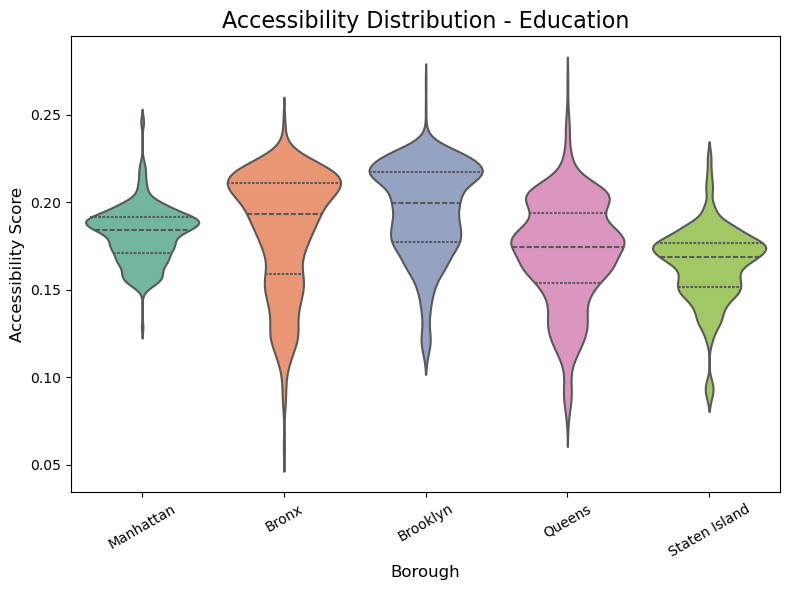

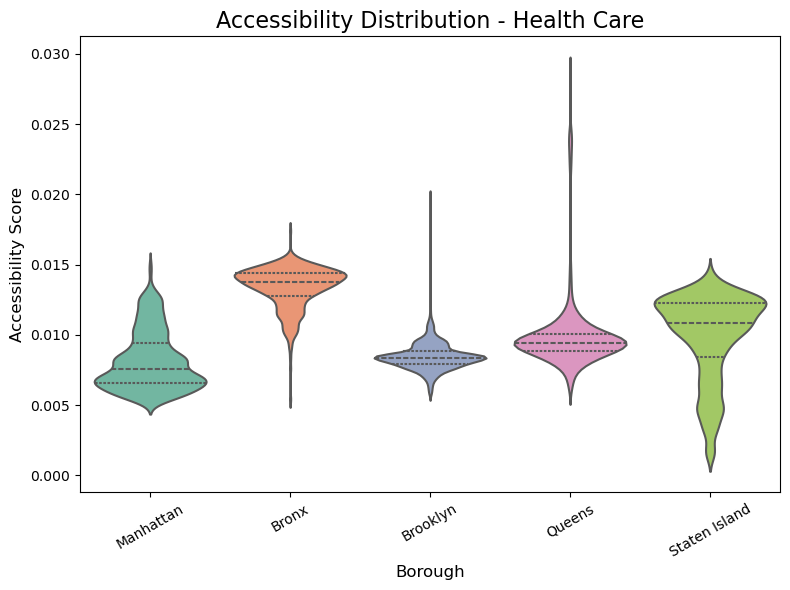

In [30]:
columns_needed = ['boroname', 'accessibility_Education', 'accessibility_Health Care']
df = NYC_census_tract[columns_needed].dropna()  # drop Na
df_education = df[['boroname', 'accessibility_Education']].rename(columns={'accessibility_Education': 'Value'})
df_public_health = df[['boroname', 'accessibility_Health Care']].rename(columns={'accessibility_Health Care': 'Value'})

# Education
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df_education, x='boroname', y='Value', inner="quartile",  # set inner to make the graph clear
    linewidth=1.5, scale='width', palette="Set2", bw=0.2  # control the width
)
plt.title("Accessibility Distribution - Education", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Accessibility Score", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Health Care
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df_public_health, x='boroname', y='Value', inner="quartile",
    linewidth=1.5, scale='width', palette="Set2", bw=0.2
)
plt.title("Accessibility Distribution - Health Care", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Accessibility Score", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**(2) Accessibility Distribution - Education**

- Distribution Patterns:
  - It can be observed from the graph that the distribution of education accessibility in each borough presents different patterns. For instance, Brooklyn's distribution is relatively dispersed with a wider shape, indicating a larger variation in education accessibility among different census tracts in this borough. There exist areas with both relatively high and low accessibility.
  - In contrast, Staten Island's distribution is relatively concentrated with a narrower shape, suggesting that the education accessibility in various census tracts within this borough is relatively close, with less variation.

- Mean Comparison:
  - In terms of the mean, Brooklyn has the highest mean value of 0.195286, indicating that overall, this borough has relatively better education accessibility. On the other hand, Queens has a relatively lower mean value of 0.171001, which might imply that the overall performance of education resource accessibility in this borough is slightly inferior.
  - The means of Manhattan and Bronx are 0.183482 and 0.183482 respectively, at a medium level. However, their distribution patterns differ. Manhattan's distribution is relatively more concentrated in the higher value range, while Bronx's distribution is more dispersed.

**(3) Accessibility Distribution - Health Care**
- Distribution Patterns:
  - Queens has the most dispersed distribution of health care accessibility, with a long and narrow shape and a long "tail". This indicates that there is a significant variation in health care accessibility among different census tracts in this borough, possibly suggesting an uneven distribution of medical resources.
  - Manhattan's distribution is relatively concentrated and has a more regular shape, indicating that the health care accessibility in various census tracts in this borough is relatively uniform with less variation.

- Mean Comparison:
  - Queens has the highest mean value of 0.009974 for health care accessibility. However, due to its large degree of dispersion in the distribution, it implies that although the overall mean is high, there are some areas with relatively low accessibility that lower the overall balance.
  - Brooklyn has a mean value of 0.008444, at a medium level, and its distribution pattern also shows a certain degree of dispersion.
  - The means of Staten Island and Bronx are relatively low, at 0.009886 and 0.013391 respectively, and their distribution patterns also have their own characteristics. Staten Island is relatively concentrated, while Bronx is more dispersed.

**(4) Comprehensive Comparison**
- In terms of education accessibility, Brooklyn performs relatively well with a higher mean and a wider distribution, indicating good coverage of educational resources but also a certain degree of imbalance. Staten Island, on the other hand, is relatively balanced but has a slightly lower overall accessibility level.
- In terms of health care accessibility, Queens has a high mean but a large degree of dispersion in the distribution, indicating an uneven distribution of resources. Manhattan is relatively balanced and shows a relatively stable overall performance.

<a id="3_2"></a>
### 3.2 Equity Assessment of Different Boroughs

**Lorenz Curve and Gini Coefficient Analysis**

(1) Lorenz Curve: Definition and Interpretation
- The **Lorenz Curve** is a graphical representation of inequality. It compares the cumulative proportion of a population (x-axis) to the cumulative proportion of a resource (y-axis), such as income, wealth, or accessibility.

- Key Features:
  - **Equality Line**: The diagonal line represents perfect equality. For example, 20% of the population would have access to 20% of the resource.
  - **Lorenz Curve**: The curve below the diagonal represents the actual distribution. The farther it is from the diagonal, the greater the inequality.

(2) Mathematical Representation:
- Let:
  - $X$: Cumulative population proportion
  - $Y$: Cumulative resource proportion (e.g., accessibility)

- The Lorenz Curve is a plot of $Y$ versus $X$, where ( *Jann, 2016* ):

$$
X = \frac{\sum_{i=1}^{k} P_i}{\sum_{i=1}^{n} P_i}, \quad Y = \frac{\sum_{i=1}^{k} R_i}{\sum_{i=1}^{n} R_i}
$$

- Here:
  - $P_i$: Population of tract $i$
  - $R_i$: Resource (e.g., accessibility) of tract $i$
  - $k$: Index of ordered tracts by resource value

**Gini Coefficient: Definition and Calculation**
- The **Gini Coefficient** is a numerical measure of inequality derived from the Lorenz Curve. It quantifies the area between the Lorenz Curve and the Equality Line.

(1) Formula:

- The Gini Coefficient is calculated as ( *Darkwah et al., 2016* ):

$$
G = 1 - 2 \times \int_{0}^{1} Y(X) dX
$$


- Where:
  - $\Delta X_i$: Difference in cumulative population share between consecutive points

(2) Interpretation:
- **$G = 0$**: Perfect equality
- **$G = 1$**: Maximum inequality

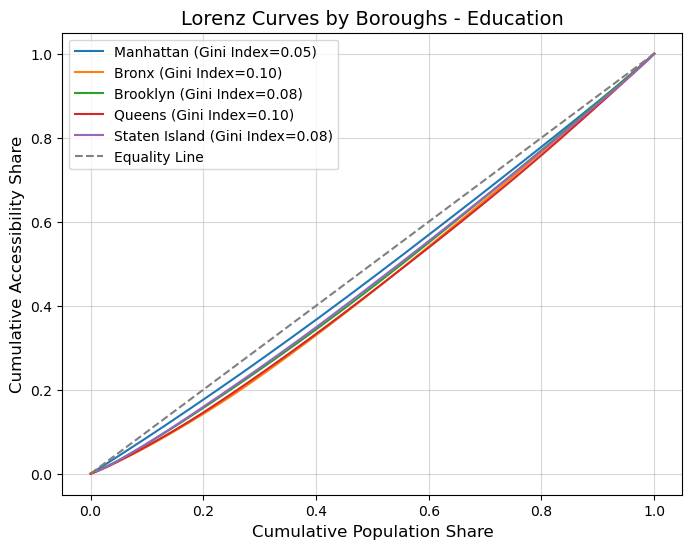

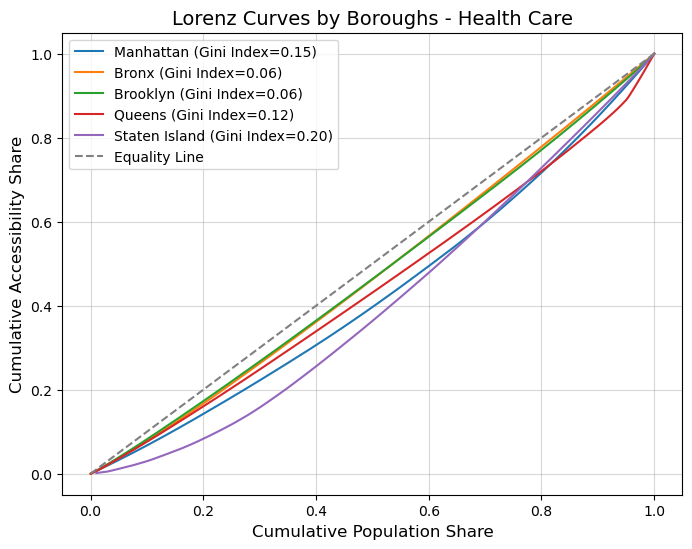

In [31]:
def weighted_gini(accessibility, population):
    """
    Calculate the weighted Gini coefficient
    :param accessibility: 1D array, accessibility data
    :param population: 1D array, population data
    :return: Gini coefficient, cumulative population ratio, cumulative accessibility ratio

    """
    # Sorting
    sorted_indices = np.argsort(accessibility)
    accessibility = accessibility[sorted_indices]
    population = population[sorted_indices]
    
    # Cumulative values
    cum_population = np.cumsum(population)
    total_population = cum_population[-1]
    cum_population_ratio = cum_population / total_population
    
    cum_accessibility = np.cumsum(accessibility * population)
    total_accessibility = cum_accessibility[-1]
    cum_accessibility_ratio = cum_accessibility / total_accessibility
    
    # Gini coefficient
    gini = 1 - 2 * np.sum(cum_accessibility_ratio[:-1] * np.diff(cum_population_ratio))
    return gini, cum_population_ratio, cum_accessibility_ratio

def plot_lorenz_curves_by_borough(data, boroname_col, accessibility_col, population_col, fac_name):
    """
    Plot Lorenz curves for each borough
    :param data: DataFrame containing the data
    :param boroname_col: Column name for borough names
    :param accessibility_col: Column name for accessibility data
    :param population_col: Column name for population data
    :param fac_name: Name of the facility (Education or Health Care)
    """
    plt.figure(figsize=(8, 6))
    unique_boros = data[boroname_col].unique()
    
    for boro in unique_boros:
        # Filter data for the current borough
        boro_data = data[data[boroname_col] == boro]
        accessibility = boro_data[accessibility_col].values
        population = boro_data[population_col].values
        
        # Calculate Gini coefficient and cumulative ratios
        gini, cum_population_ratio, cum_accessibility_ratio = weighted_gini(accessibility, population)
        plt.plot(cum_population_ratio, cum_accessibility_ratio, label=f"{boro} (Gini Index={gini:.2f})")
    
    # Add equality line
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equality Line")
    plt.title("Lorenz Curves by Boroughs"+" - "+fac_name, fontsize=14)
    plt.xlabel("Cumulative Population Share", fontsize=12)
    plt.ylabel("Cumulative Accessibility Share", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


# Plot Lorenz curves for each borough
plot_lorenz_curves_by_borough(NYC_census_tract, "boroname", "accessibility_Education", "Total Population", "Education")
plot_lorenz_curves_by_borough(NYC_census_tract, "boroname", "accessibility_Health Care", "Total Population", "Health Care")

**Observations and Analysis**

The figure above shows the Lorenz Curve by Borough, with each colored curve corresponding to one borough. The horizontal axis represents the proportion of the cumulative distribution of the city's population from low to high, and the vertical axis represents the cumulative proportion of the accessibility under the corresponding population (such as the accessibility of education and medical facilities). The grey dashed Equality Line represents a completely equal distribution, and the more the curve deviates from the diagonal, the higher the inequality.

The Gini Coefficient of different administrative regions has certain differences, as seen from the legend. The Gini Coefficient is usually between **0** and **1**:
- **0** means perfect equality.
- **1** means extreme inequality.

(1) Manhattan (Gini = 0.05)  
The curve is closest to the diagonal line, and the Gini Coefficient is about **0.05**, indicating that the accessibility is relatively balanced within the region.  
- Most census tracts enjoy similar levels of accessibility, with very few extremely high or extremely low values.  
- One possible explanation is that Manhattan's dense population, relatively uniform distribution of public facilities, and high accessibility by public transportation make the accessibility gap smaller.

(2) Bronx and Queens (Gini = 0.10)  
Both have a Gini Coefficient of **0.10**, implying higher internal inequality than in Manhattan.  
- This may indicate that the two boroughs are more dispersed in terms of geographic scope or residential patterns.  
- Some census areas may have better access to public facilities or transport, while others have relatively low accessibility, widening the gap.

(3) Staten Island (Gini = 0.08) and Brooklyn (Gini = 0.08)  
Compared to Queens and the Bronx, the Gini Coefficient is slightly smaller (**0.08**), but it is still significantly higher than Manhattan.  
- This shows that there is still a certain degree of inequality in accessibility between the two, but it is not as prominent as in Queens and the Bronx.  
- In areas such as Staten Island, the pattern of population density and facility distribution tends to result in some census areas having better access to transportation and facilities, while others are lagging behind, creating a moderate imbalance.

**Policy and Planning Implications**

(1) Resource Allocation Priority  
- Queens and the Bronx, which have the highest Gini Coefficient, may need more public facilities or transit improvements to reduce internal inequality.  
- If these two districts have high poverty rates, additional resources should be allocated.

(2) The Relative Balance of Manhattan    
- Manhattan has the most balanced accessibility and the lowest Gini Coefficient, but it does not mean that all regions are equally good.  
- A refined diagnosis needs to be combined with actual geography and population distribution.

(3) Direction of Subsequent Analysis  
- This measure of inequality can be further cross-examined with factors such as demographics (age, race), housing prices, or employment location to see if there are specific disadvantaged groups concentrated in areas with low accessibility.  
- By comparing the Gini Coefficient in time series or with other cities, the development trend and improvement degree of the region can also be assessed.

**Multi-dimensional Analysis: Supplementing Single-dimensional Lorenz Curve and Gini Coefficient**

- The Lorenz Curve and Gini Coefficient focus on single indicators (e.g., Education Accessibility or Health Care Accessibility). While these provide insights into specific dimensions of inequality, they fail to capture the overall distribution across multiple dimensions.

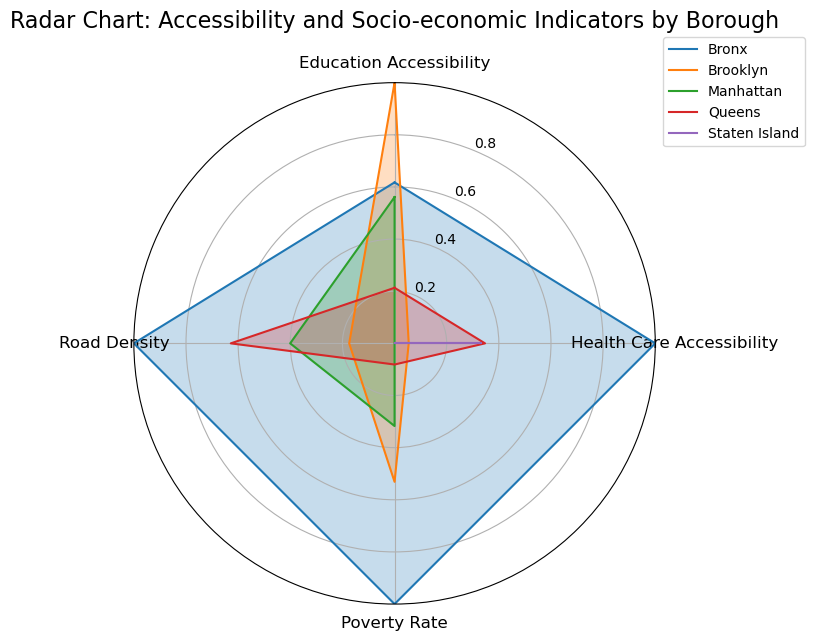

In [32]:
# Calculate Education Accessibility and Health Care Accessibility by Borough
education_accessibility = NYC_census_tract.groupby('boroname')['accessibility_Education'].mean()
health_accessibility = NYC_census_tract.groupby('boroname')['accessibility_Health Care'].mean()

# Calculate Poverty Rate by Borough
poverty_rate = NYC_census_tract.groupby('boroname').apply(
    lambda x: x['Poverty Population'].sum() / x['Total Population'].sum()
)

# Calculate Road Density by Borough
road_density = NYC_census_tract.groupby('boroname')['Road Density'].mean()

# Combine data into a dictionary
data = {
    "Borough": education_accessibility.index.tolist(),
    "Education Accessibility": education_accessibility.tolist(),
    "Health Care Accessibility": health_accessibility.tolist(),
    "Poverty Rate": poverty_rate.tolist(),
    "Road Density": road_density.tolist(),
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Normalize data (excluding the "Borough" column)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.iloc[:, 1:])  # Normalize numerical columns
normalized_df = pd.DataFrame(normalized_data, columns=df.columns[1:])
normalized_df.insert(0, 'Borough', df['Borough'])  # Insert Borough column

# Prepare data for radar chart
categories = list(normalized_df.columns[1:])  # Extract indicator names
num_vars = len(categories)

# Create angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Initialize radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot radar chart for each borough
for i, row in normalized_df.iterrows():
    values = row.iloc[1:].tolist() + row.iloc[1:2].tolist()  # Close the loop
    ax.plot(angles, values, label=row["Borough"])
    ax.fill(angles, values, alpha=0.25)

# Set radar chart style
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], fontsize=10)
ax.set_ylim(0, 1)

# Add title and legend
plt.title("Radar Chart: Accessibility and Socio-economic Indicators by Borough", fontsize=16, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.tight_layout()
plt.show()

**Analysis**  

(1) Bronx
- Health Care Accessibility and Education Accessibility are notably lower compared to other boroughs.
- High Poverty Rate reinforces the idea that resource inequality primarily stems from these two dimensions.

(2) Manhattan
- High and balanced levels of Education Accessibility and Health Care Accessibility.
- The lowest Poverty Rate aligns with the results from the Lorenz Curve, confirming equitable resource allocation.

**Integrating Gini Coefficient with Multi-dimensional Analysis**

(1) High Gini Coefficient Areas (e.g., Bronx and Queens)
- In radar charts, these regions often exhibit extremely low values for specific indicators (e.g., Health Care Accessibility), providing a direct explanation for the observed inequalities.

(2) Low Gini Coefficient Areas (e.g., Manhattan)
- In radar charts, these regions typically display balanced performance across multiple dimensions, highlighting equitable resource distribution.


<a id="3_3"></a>
### 3.3 Equity Assessment of Different Demographic Groups

#### Between Different Income status

In [33]:
# Calculate quartiles
quartiles = NYC_census_tract['Median Income (USD)'].quantile([0.25, 0.5, 0.75])

# Define a classification function
def classify_income(row):
    if row <= quartiles[0.25]:
        return "Low Income"
    elif quartiles[0.25] < row <= quartiles[0.5]:
        return "Lower-Middle Income"
    elif quartiles[0.5] < row <= quartiles[0.75]:
        return "Upper-Middle Income"
    else:
        return "High Income"

# Create a new column and classify income
NYC_census_tract['Income Status'] = NYC_census_tract['Median Income (USD)'].apply(classify_income)
display(NYC_census_tract.head(10))
print("shape:", NYC_census_tract.shape)


borocode   boroname        geoid  \
0        1  Manhattan  36061000100   
1        1  Manhattan  36061001401   
2        1  Manhattan  36061001402   
3        1  Manhattan  36061001800   
4        1  Manhattan  36061002201   
5        1  Manhattan  36061002601   
6        1  Manhattan  36061002602   
7        1  Manhattan  36061002800   
8        1  Manhattan  36061003100   
9        1  Manhattan  36061003200   

                                            geometry  Total Population  \
0  MULTIPOLYGON (((580787.267 4504805.375, 580819...               0.0   
1  MULTIPOLYGON (((585444.188 4507772.701, 585514...            3165.0   
2  MULTIPOLYGON (((585718.928 4508068.7, 585790.3...            3286.0   
3  MULTIPOLYGON (((585313.281 4508223.568, 585324...            6948.0   
4  MULTIPOLYGON (((586251.705 4508169.291, 586248...            6748.0   
5  MULTIPOLYGON (((586405.487 4508455.689, 586373...            4592.0   
6  MULTIPOLYGON (((586512.887 4508655.259, 586485...            3632.0   
7  MULTIPOLYGON (((586702.647 4509006.581, 586661...            6364.0   
8  MULTIPOLYGON (((584298.712 4508087.314, 584339...            2667.0   
9  MULTIPOLYGON (((586145.288 4508937.665, 586123...            7523.0   

   White Population  Black Population  Asian Population  \
0               0.0               0.0               0.0   
1            2260.0              96.0             251.0   
2            1150.0             250.0            1099.0   
3            2619.0             405.0            3171.0   
4            2173.0            1327.0             880.0   
5            1441.0             734.0             758.0   
6            2219.0             289.0             392.0   
7            2433.0             338.0            1357.0   
8            1299.0             312.0             704.0   
9            5999.0             207.0             581.0   

   Other Races Population  Poverty Population  Median Income (USD)  area_km2  \
0                     0.0                 0.0                  0.0  0.171110   
1                   219.0               162.0              46837.0  0.093414   
2                   524.0               946.0              44000.0  0.113849   
3                   329.0               873.0              37075.0  0.222764   
4                  2079.0              1849.0              30033.0  0.161569   
5                   861.0              1597.0              19983.0  0.105958   
6                   398.0               625.0              51757.0  0.103511   
7                  1031.0              1527.0              37852.0  0.183250   
8                   125.0               198.0              23647.0  0.204913   
9                   521.0              1308.0              70353.0  0.216845   

   Road Density  Education Facility Density  Health Care Facility Density  \
0      0.000000                           0                             0   
1     25.657053                           0                             7   
2     36.129644                           2                             1   
3     35.818790                           5                            13   
4     19.262698                           4                             0   
5     27.027766                           4                             2   
6     22.864433                           0                             1   
7     22.576522                           2                             1   
8     17.437293                           0                             5   
9     19.764479                           5                             0   

   Poverty Ratio  Population Density  accessibility_Education  \
0       0.000000            0.000000                 0.128676   
1       0.051185        33881.370808                 0.193922   
2       0.287888        28862.855952                 0.193863   
3       0.125648        31190.003758                 0.190209   
4       0.274007        41765.435762                 0.199299   

shape: (2325, 20)


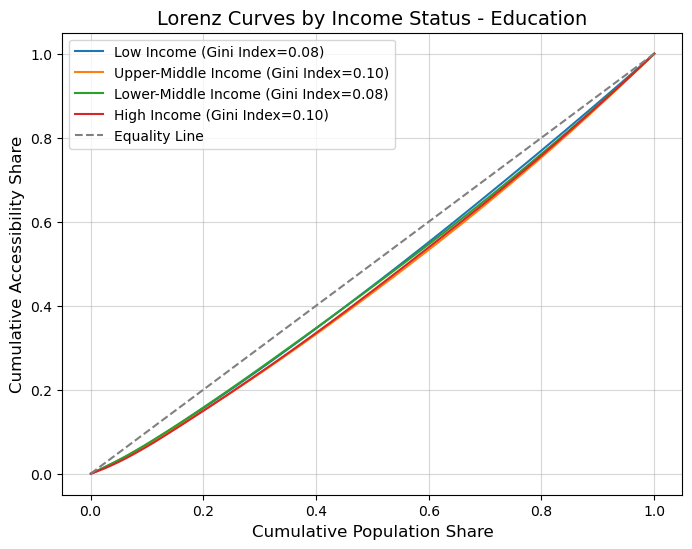

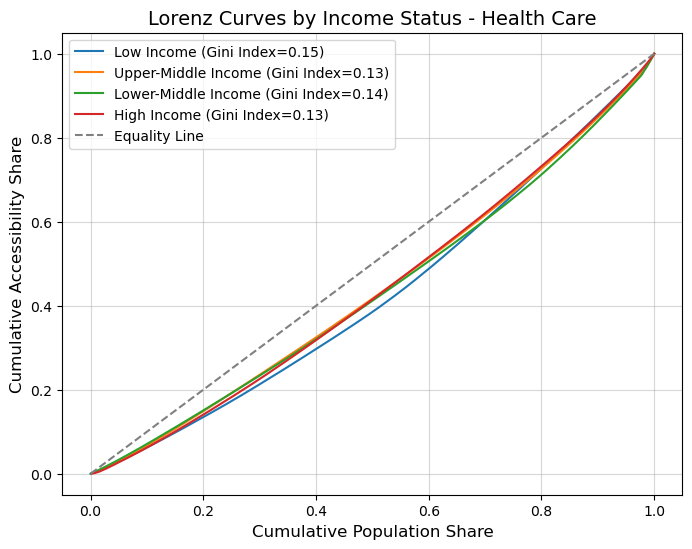

In [34]:
def plot_lorenz_by_income(data, accessibility_col, income_status_col, fac_name):
    """
    Plot Lorenz curves by Income Status.
    :param data: DataFrame containing the data
    :param accessibility_col: Name of the accessibility column
    :param income_status_col: Name of the income status column
    :param fac_name: Name of the facility (Education or Health Care)
    """
    plt.figure(figsize=(8, 6))
    
    # Get unique income statuses
    income_statuses = data[income_status_col].unique()
    
    for income_status in income_statuses:
        # Filter data for the current income status
        income_data = data[data[income_status_col] == income_status]
        accessibility = income_data[accessibility_col].values
        population = income_data["Total Population"].values
        
        # Calculate Gini coefficient and cumulative ratios
        gini, cum_population_ratio, cum_accessibility_ratio = weighted_gini(accessibility, population)
        plt.plot(cum_population_ratio, cum_accessibility_ratio, label=f"{income_status} (Gini Index={gini:.2f})")
    
    # Add Equality Line
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equality Line")
    plt.title("Lorenz Curves by Income Status - " + fac_name, fontsize=14)
    plt.xlabel("Cumulative Population Share", fontsize=12)
    plt.ylabel("Cumulative Accessibility Share", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Plot Lorenz curves by income status
plot_lorenz_by_income(NYC_census_tract, "accessibility_Education", "Income Status", "Education")
plot_lorenz_by_income(NYC_census_tract, "accessibility_Health Care", "Income Status", "Health Care")


**(1) Low-Income Group (Education Gini = 0.08, Health Care Gini = 0.09)**
- **Lorenz Curve Observation**: The Lorenz Curve for the low-income group is closest to the Equality Line for both education and healthcare accessibility, indicating the most balanced distribution of resources.
- **Explanation**:
  - Public facilities (e.g., schools and healthcare) may prioritize economically disadvantaged areas to ensure equitable access.
  - Urban policies may focus on allocating more resources to low-income regions to reduce social disparities.

**(2) Lower-Middle Income Group (Education Gini = 0.08, Health Care Gini = 0.10)**
- **Lorenz Curve Observation**: This group exhibits a similar Lorenz Curve to the low-income group for education but shows slightly greater inequality in healthcare accessibility.
- **Explanation**:
  - This group may reside in areas with moderate population density and adequate public resource coverage for education.
  - However, healthcare facilities might be less accessible due to geographic or demographic factors.

**(3) Upper-Middle Income Group (Education Gini = 0.10, Health Care Gini = 0.12)**
- **Lorenz Curve Observation**: The Lorenz Curve for this group starts to deviate significantly from the Equality Line, particularly for healthcare accessibility, indicating increasing inequality.
- **Explanation**:
  - Upper-middle-income populations may reside in suburban or less densely populated areas with fewer public facilities, resulting in reduced accessibility.

**(4)High-Income Group (Education Gini = 0.10, Health Care Gini = 0.13)**
- **Lorenz Curve Observation**: The Lorenz Curve for the high-income group deviates the most from the Equality Line, particularly for healthcare accessibility, highlighting the greatest inequality in resource distribution.
- **Explanation**:
  - High-income areas tend to have lower population densities and dispersed public resources, leading to disparities in accessibility.
  - Wealthier households may rely more on private resources (e.g., private schools and healthcare), which reduces the emphasis on public facilities in these regions.

**(5) Cross-Group Analysis**
- **Education Accessibility**: 
  - The **Low-Income** and **Lower-Middle Income** groups exhibit similar and relatively balanced accessibility, likely due to targeted urban policies.
  - The **Upper-Middle Income** and **High-Income** groups show increasing levels of inequality, potentially due to geographic and socio-economic factors such as suburbanization and reliance on private resources.
- **Health Care Accessibility**:
  - The disparities are more pronounced across all income groups compared to education accessibility, with higher Gini Coefficients.
  - This suggests systemic issues in healthcare facility distribution that disproportionately impact higher-income groups.



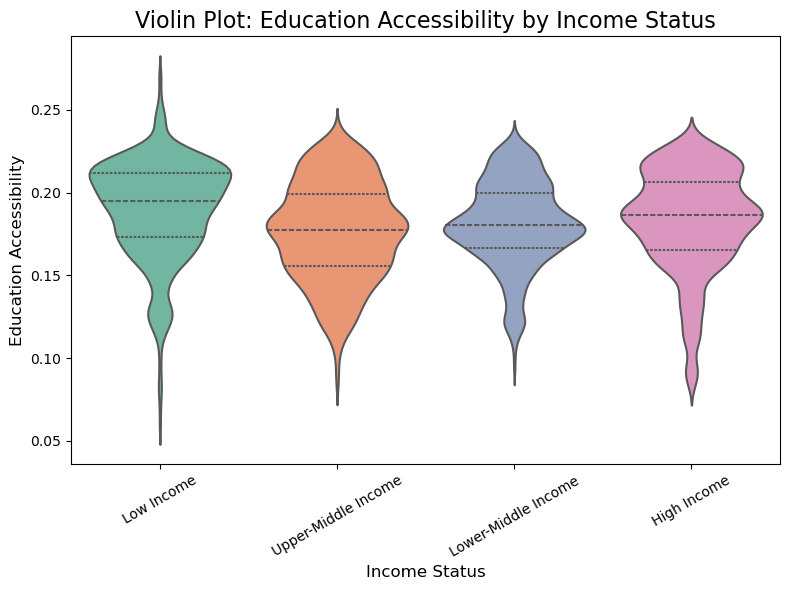

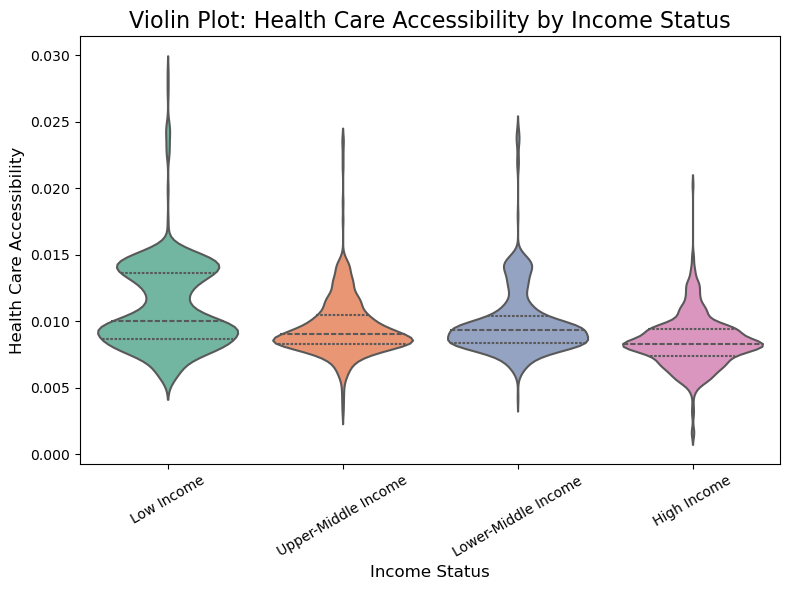

In [36]:
# Prepare the data for violin plots
columns_needed = ['Income Status', 'accessibility_Education', 'accessibility_Health Care']
df_violin = NYC_census_tract[columns_needed].dropna().copy()

# Rename columns for better readability in plots
df_violin = df_violin.rename(columns={
    'accessibility_Education': 'Education Accessibility',
    'accessibility_Health Care': 'Health Care Accessibility'
})

# Education Accessibility Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df_violin,
    x='Income Status',
    y='Education Accessibility',
    inner="quartile",  # Display quartiles inside the plot
    linewidth=1.5,
    scale='width',
    palette="Set2",
    bw=0.2  # Bandwidth for kernel density estimation
)
plt.title("Violin Plot: Education Accessibility by Income Status", fontsize=16)
plt.xlabel("Income Status", fontsize=12)
plt.ylabel("Education Accessibility", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Health Care Accessibility Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df_violin,
    x='Income Status',
    y='Health Care Accessibility',
    inner="quartile",
    linewidth=1.5,
    scale='width',
    palette="Set2",
    bw=0.2
)
plt.title("Violin Plot: Health Care Accessibility by Income Status", fontsize=16)
plt.xlabel("Income Status", fontsize=12)
plt.ylabel("Health Care Accessibility", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**Observations and Cross-Validation**

- Validation of Lorenz Curve Findings
    - The violin plots validate the findings of the Lorenz Curve: For example, the broader range of accessibility within the low-income group explains why its Lorenz Curve is closer to the Equality Line, indicating relatively balanced accessibility.

- Middle-Income Groups
    - The higher Gini Coefficients for middle-income groups (upper-middle and lower-middle) can be attributed to their accessibility distributions: These groups include both well-served and underserved census tracts, leading to a higher overall inequality.

- High-Income Group
    - The concentrated distributions in violin plots explain why the Gini Coefficient for the high-income group is higher but not excessively so: It reflects better overall accessibility with relatively equal resource allocation across census tracts.


#### Between different races


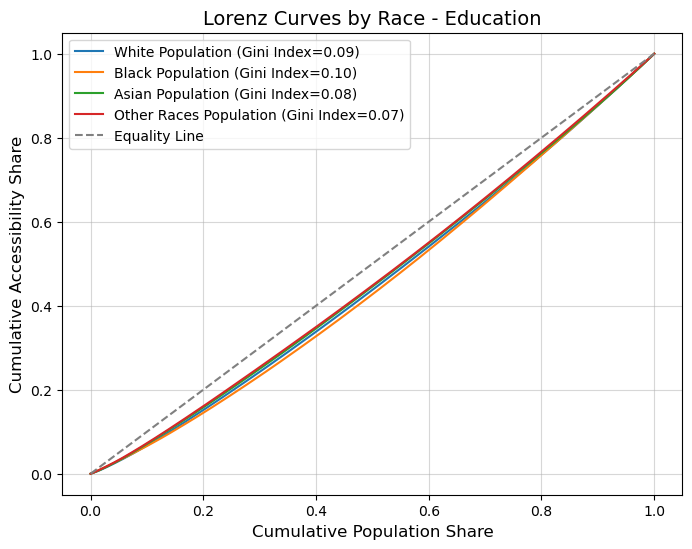

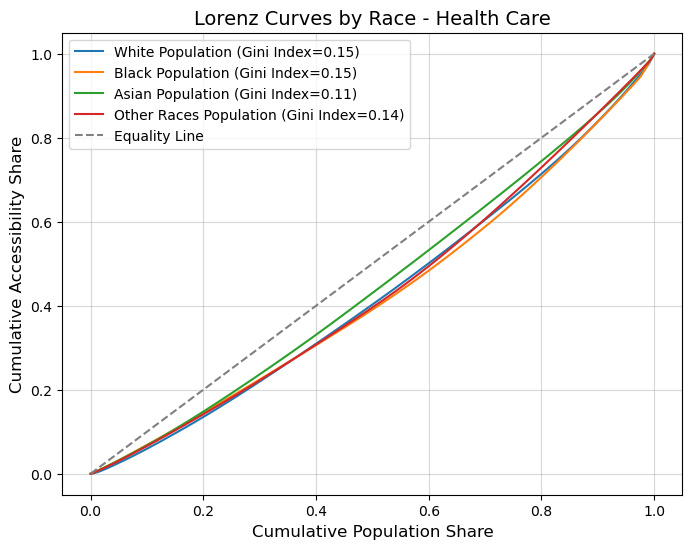

In [37]:
def plot_lorenz_by_race(data, accessibility_col, race_cols, fac_name):
    """
    Plot Lorenz curves by race.
    :param data: DataFrame containing the data
    :param accessibility_col: Name of the accessibility column
    :param race_cols: Names of the population columns for different races
    :param fac_name: Name of the facility (Education or Health Care)
    """
    plt.figure(figsize=(8, 6))
    
    for race in race_cols:
        # Extract data for the specified race
        accessibility = data[accessibility_col].values
        population = data[race].values
        
        # Calculate Gini coefficient and cumulative ratios
        gini, cum_population_ratio, cum_accessibility_ratio = weighted_gini(accessibility, population)
        plt.plot(cum_population_ratio, cum_accessibility_ratio, label=f"{race} (Gini Index={gini:.2f})")
    
    # Add Equality Line
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equality Line")
    plt.title("Lorenz Curves by Race"+" - "+fac_name, fontsize=14)
    plt.xlabel("Cumulative Population Share", fontsize=12)
    plt.ylabel("Cumulative Accessibility Share", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Call the function to plot Lorenz curves for different races
race_columns = ["White Population", "Black Population", "Asian Population", "Other Races Population"]
plot_lorenz_by_race(NYC_census_tract, "accessibility_Education", race_columns, "Education")
plot_lorenz_by_race(NYC_census_tract, "accessibility_Health Care", race_columns, "Health Care")


**(1) Observations from the Lorenz Curve and Gini Coefficients**
- The **Gini Coefficient** quantifies this inequality:
  - **White Population (Gini = 0.09 for Education, 0.12 for Health Care)**: Moderate inequality with the curve slightly deviating from the Equality Line.
  - **Black Population (Gini = 0.10 for Education, 0.15 for Health Care)**: Highest inequality among the racial groups.
  - **Asian Population (Gini = 0.08 for Education, 0.10 for Health Care)**: Most equal distribution with the curve closest to the Equality Line.


**(2) Key Observations: Education Accessibility**
- **White Population**:
  - Accessibility distribution is relatively balanced but slightly less equal compared to the Asian population.
  - The curve suggests that accessibility is better distributed across census tracts compared to the Black population.
- **Black Population**:
  - Highest Gini Coefficient indicates greater inequality in accessibility.
  - The curve deviates more from the Equality Line, showing that some census tracts have significantly lower accessibility.
  - This may highlight systemic issues or historical inequities affecting access to education facilities for Black communities.
- **Asian Population**:
  - Accessibility is the most equally distributed among all groups.
  - The Lorenz Curve is closest to the Equality Line, and the Gini Coefficient is the lowest.


**(3) Key Observations: Health Care Accessibility**
- **White Population**:
  - Compared to education, the Gini Coefficient for health care shows a slightly higher level of inequality.
  - Accessibility is better than that of the Black population but still exhibits noticeable disparities.
- **Black Population**:
  - The Gini Coefficient for health care is significantly higher than for education, indicating more pronounced inequality.
  - The Lorenz Curve's deviation suggests that access to health care facilities is notably unequal, emphasizing the need for targeted policy interventions.
- **Asian Population**:
  - Similar to education, the Asian population has the most equal distribution of health care accessibility.
  - The Gini Coefficient remains the lowest among the groups, indicating consistent equity across resources.


<a id="3_4"></a>
### 3.4 Evaluation of Socio-economic Factors’ Impact on Facility Accessibility

#### [SHapley Additive exPlanations (SHAP)](https://christophm.github.io/interpretable-ml-book/shap.html)

According to the [SHAP documentation](https://shap.readthedocs.io/en/latest/) and [Definition](https://christophm.github.io/interpretable-ml-book/shap.html#definition), **SHAP** values are a method to measure and explain each feature's contribution to the final outcome of any machine learning model.  

Unlike traditional importance-based methods, which offer only global importance insights without capturing **individually-specific** contributions or the **direction (positive or negative)** of features' effects on the targeted variable, SHAP values deliver a detailed, instance-specific breakdown that indicates both the magnitude and direction of each feature's impact on the target variable ( *Wang et al., 2024* ).

In order to analyze selected socio-economic indicators' impacts on the education/health care facilities' accessibility in NYC, this project utilizes the following SHAP value-related plots for analysis:

- **(1) [SHAP Summary Plot](https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot):**  
  The summary plot combines feature **importance** with **feature effects**, showing the distribution of SHAP values for each feature across all **individual record instances**. Each point represents a Shapley value for a specific feature of a data sample instance, illustrating both the magnitude of the feature's impact and whether it drives predictions **positively** or **negatively**.

- **(2) [SHAP Feature Importance](https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance):**  
  This plot ranks the features based on their **average SHAP values** and provides an overall view of which features have the greatest influence on the model's predictions. It can help us identify the most critical feature(s) affecting facility accessibility.

- **(3) [SHAP Dependence Plot](https://christophm.github.io/interpretable-ml-book/shap.html#shap-dependence-plot):**  
  This plot shows the relationship between a single **feature's values** and its corresponding **SHAP values**, revealing how changes in the feature impact the model's predictions. It can also interact with another feature, which can uncover dependencies between features and their combined effects on model predictions.

The machine learning model for this project's dataset's modeling and SHAP value calculation is [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html), which is well-suited for handling large datasets and complex feature relationships, making it an ideal choice for evaluating the socio-economic factors influencing NYC facility accessibility through SHAP value analysis.

Before conducting the analysis, please make sure you have installed the [shap](https://shap.readthedocs.io/en/latest/) and [xgboost](https://xgboost.readthedocs.io/en/stable/install.html) packages in your environment.


In [38]:
# Extract the data needed for the model
columns_for_analysis = ['accessibility_Education', 'accessibility_Health Care', 'Median Income (USD)',
              'Road Density', 'Education Facility Density', 'Health Care Facility Density', 'Poverty Ratio', 'Population Density']
Importance_analysis_data = NYC_census_tract[columns_for_analysis]
display(Importance_analysis_data.head())
print("shape:", Importance_analysis_data.shape)

accessibility_Education  accessibility_Health Care  Median Income (USD)  \
0                 0.128676                   0.005544                  0.0   
1                 0.193922                   0.006775              46837.0   
2                 0.193863                   0.006822              44000.0   
3                 0.190209                   0.006654              37075.0   
4                 0.199299                   0.007070              30033.0   

   Road Density  Education Facility Density  Health Care Facility Density  \
0      0.000000                           0                             0   
1     25.657053                           0                             7   
2     36.129644                           2                             1   
3     35.818790                           5                            13   
4     19.262698                           4                             0   

   Poverty Ratio  Population Density  
0       0.000000            0.000000  
1       0.051185        33881.370808  
2       0.287888        28862.855952  
3       0.125648        31190.003758  
4       0.274007        41765.435762

shape: (2325, 8)


#### SHAP Summary Plot

**(1) Define the XGBoost models and SHAP explainers for two types of accessibility**

In [39]:
# 1. Education Facilities
# Define the features (X) and target variable (y)
X_edu = Importance_analysis_data[['Median Income (USD)', 'Road Density', 
                              'Education Facility Density', 'Poverty Ratio', 'Population Density']]
y_edu = Importance_analysis_data['accessibility_Education']

# Initialize the XGBoost regressor model for Education Facilities
model_edu = xgb.XGBRegressor(
    max_depth=4,             # Maximum depth of a tree
    n_estimators=150,        # Number of trees (boosting rounds)
    learning_rate=0.05,      # Learning rate
    random_state=42          # Seed for reproducibility
)
# Train the XGBoost model
model_edu.fit(X_edu, y_edu)

# Define the shap explainer for Education Facilities
explainer_edu = shap.Explainer(model_edu)
shap_values_edu = explainer_edu.shap_values(X_edu)

# 2. Health Care Facilities for Health Care Facilities
X_health = Importance_analysis_data[['Median Income (USD)', 'Road Density', 
                              'Health Care Facility Density', 'Poverty Ratio', 'Population Density']]
y_health = Importance_analysis_data['accessibility_Health Care']
model_health = xgb.XGBRegressor(
    max_depth=4,
    n_estimators=150,
    learning_rate=0.05,
    random_state=42
)
model_health.fit(X_health, y_health)

# Define the shap explainer for Health Care Facilities
explainer_health = shap.Explainer(model_health)
shap_values_health = explainer_health.shap_values(X_health)

**(2) SHAP Summary Plot for Education Facility Accessibility**

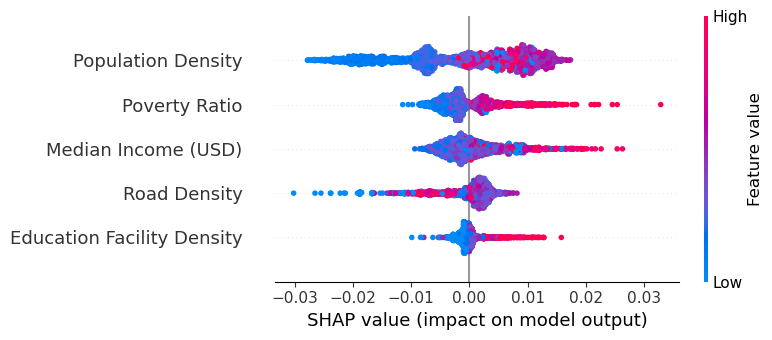

In [40]:
# Plot the SHAP summary plots for Education Facilities
shap.summary_plot(shap_values_edu, X_edu)

**Observations:**
- **Population Density**:  
   - Most significant feature influencing accessibility positively.  
   - Higher population density correlates with increased accessibility, as facilities are often concentrated in densely populated areas.

- **Median Income**:  
   - Displays mixed effects.  
   - Higher income contributes to better accessibility, but there are cases where median income has a negative effect, potentially due to resource distribution patterns.

- **Poverty Ratio**:  
   - Negative SHAP values for higher poverty ratios, suggesting accessibility diminishes as poverty increases, likely reflecting underserved areas.

- **Road Density**:  
   - Moderate positive influence, with higher road density linked to better access.

- **Education Facility Density**:  
   - Positive but less impactful than other factors.

**Insights:**
- Accessibility is primarily driven by population characteristics and infrastructure density.


**(3) SHAP Summary Plot for Health Care Facility Accessibility**

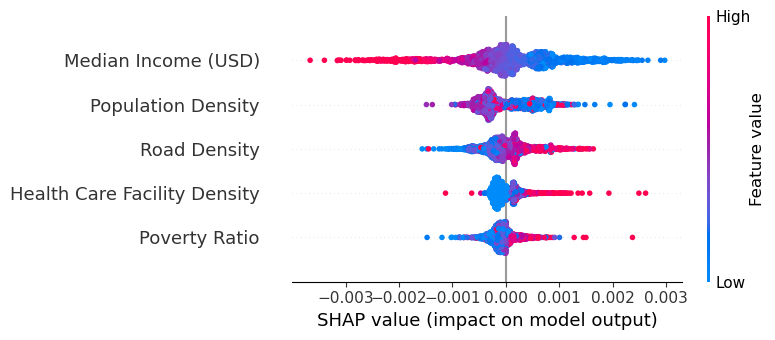

In [41]:
# Plot the SHAP summary plots for Health Care Facilities
shap.summary_plot(shap_values_health, X_health)

**Observations:**
- **Median Income**:  
   - Most impactful feature.  
   - Higher income is strongly correlated with better health care facility accessibility.

- **Population Density**:  
   - Significant but secondary compared to income, reflecting the role of demand-driven placement.

- **Road Density and Health Care Facility Density**:  
   - Both positively contribute, though their impact is less pronounced than income and population density.

- **Poverty Ratio**:  
   - Similar to education, high poverty negatively impacts accessibility.

**Insights:**
- Economic factors dominate health care facility accessibility, with spatial features playing a supportive role.


#### SHAP Feature Importance

**(1) SHAP Feature Importance Plot for Education Facility Accessibility**

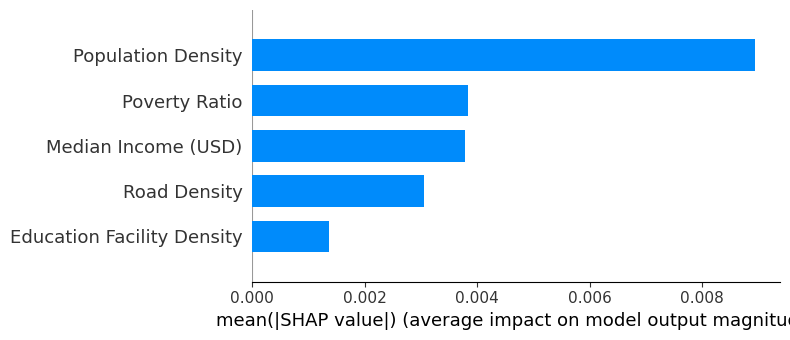

In [42]:
# Plot the SHAP Feature Importance for Education Facilities Accessibility
shap.summary_plot(shap_values_edu, X_edu, plot_type='bar')

Observations:  
- Spatial factors (e.g., population and road density) are pivotal.  
- Income and poverty indicators highlight socio-economic disparities.

**(2) SHAP Feature Importance Plot for Health Care Facility Accessibility**

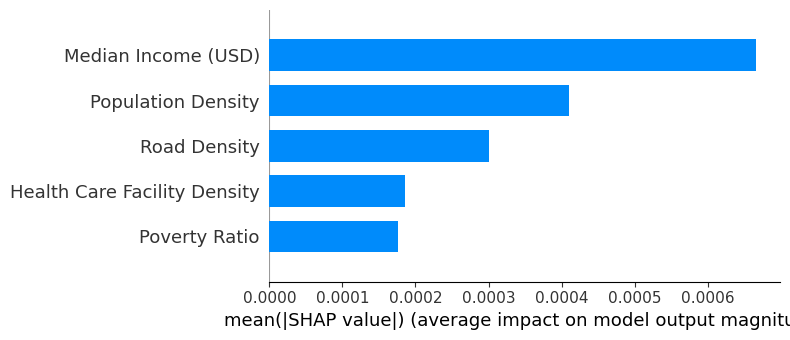

In [43]:
# Plot the SHAP Feature Importance for Health Care Facilities Accessibility
shap.summary_plot(shap_values_health, X_health, plot_type='bar')

 **Observations:**  
- Economic factors are paramount.  
- Infrastructure contributes to but does not dominate the model's predictions.


#### SHAP Dependence Plot

Based on the findings above, **Median Income** and **Population Density** are the two most significant factors influencing the accessibility of both facilities. To further explore how these two variables interact and jointly contribute to public facility accessibility, this project uses them as the basis for the SHAP dependence plot.

**(1) SHAP Dependence Plot for Education Facility Accessibility**

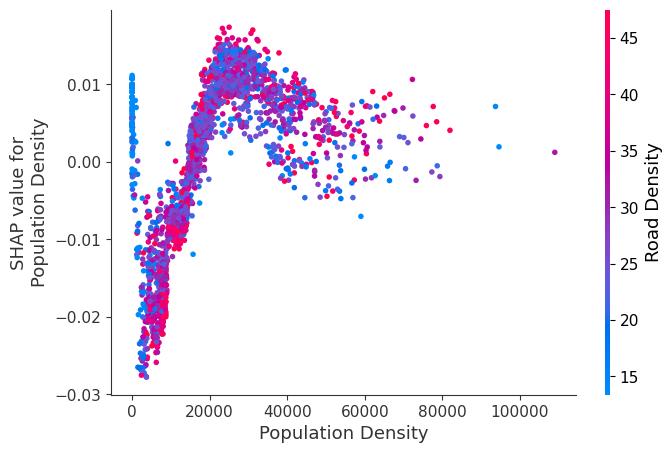

In [44]:
# Plot the SHAP Dependence Plots for Education Facilities Accessibility
# Indicators selected: Population Density and Road Density
shap.dependence_plot('Population Density', shap_values_edu, X_edu, interaction_index='Road Density', show=False)

**(2) SHAP Dependence Plot for Health Care Facility Accessibility**

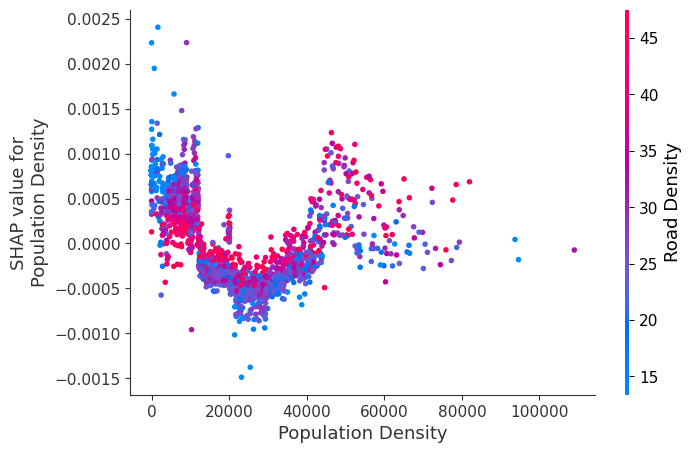

In [45]:
# Plot the SHAP Dependence Plots for Health Care Facilities Accessibility
# Indicators selected: Population Density and Road Density
shap.dependence_plot('Population Density', shap_values_health, X_health, interaction_index='Road Density', show=False)

**Education Facilities Accessibility**
- Population Density Interaction with Road Density:
  - High population density consistently leads to positive SHAP values, indicating better accessibility.  
  - Interaction with road density shows that regions with dense populations but poor road infrastructure may still face access challenges.


**Health Care Facilities Accessibility**
- Population Density Interaction with Road Density:
   - Positive SHAP values for high population densities, with road density amplifying accessibility in densely populated areas.  
   - Areas with sparse populations and low road density show diminished accessibility, highlighting inequities.


**Comparative Insights Between Education and Health Care Facilities Accessibility**
- Common Factors:
  - Both education and health care accessibility are influenced significantly by population density and median income.  
  - Higher poverty ratios consistently reduce accessibility across both facility types.

- Differences:
  - **Economic Factors**: Dominate health care accessibility, reflecting resource allocation disparities in health care.  

  - **Spatial Factors**: Education facility accessibility is more evenly distributed, with spatial factors (e.g., road density and population) playing a larger role than in health care.


**SHAP Analysis**

The SHAP analysis explores how socioeconomic and spatial factors influence access to education and healthcare facilities in New York City, providing crucial insights for policy-making and resource allocation.

Observation  

1.Co-Drivers
- population Density: High population density areas benefit from a concentration of facilities, significantly impacting accessibility.
- Median Income: Higher income areas have better access to facilities, but uneven income distribution leads to resource inequities.
- poverty Ratio: Negatively affects accessibility, highlighting resource disadvantages in low-income communities.

2.Facility-Specific Insights
- Educational Facilities: Transport infrastructure (e.g., road density) plays a critical role in accessibility. Increasing the number of schools alone cannot address issues caused by spatial and socioeconomic factors.
- Health Facilities: Accessibility challenges in high-poverty areas are primarily driven by economic factors such as median income.

3.Feature Importance
- population Density and Median Income are key drivers for both facility types.
- Educational facilities rely more on spatial factors (e.g., roads), while health facilities are more influenced by socioeconomic conditions.

4.Interaction Effects
- Population Density & Road Density: In high-density areas, strong road networks significantly enhance accessibility. Conversely, in low-density areas, poor transportation infrastructure exacerbates accessibility disadvantages.

5.Comparison of Facility Types
- Economic Disparities: Health facility accessibility is more dependent on income levels, creating greater inequities for low-income groups.
- Spatial Dependence: Educational facilities are more influenced by transport infrastructure, emphasizing the need for improved urban planning.

Conclusion  
The SHAP analysis highlights the pivotal roles of **Population Density** and **Median Income** in shaping facility accessibility while exposing social inequities caused by poverty and infrastructure limitations. These insights provide policymakers with actionable guidance to improve equitable access to education and healthcare facilities in New York City.


<a id="4"></a>
## **4. Conclusion**

**Observation and research**
- Spatial distribution analysis of accessibility of public facilities  
Spatial distribution: The report analyzes the spatial accessibility of education and healthcare facilities in New York City, showing that facilities are not evenly distributed within census tracts. For example, Brooklyn has greater diversity in access to educational facilities, while Staten Island is more concentrated.  
Overall characteristics: Using the Gaussian decay two-step floating capture Area method (2SFCA), we found that educational accessibility was generally high in Brooklyn, while medical facilities were more evenly distributed in Manhattan.
- Equity assessment of facility accessibility  
Regional equity: There are differences in the distribution of facilities across the five boroughs. Brooklyn's educational resources cover a wide range but are unevenly distributed, while Queens' medical resources, although the overall average is higher, are widely distributed.  
Demographic group equity: Analysis of race and income level data shows that low-income and some racial groups face disadvantages in access to public facilities. These inequalities are most pronounced in the Bronx and Queens.
- Importance assessment of relevant factors  
Socio-economic factors: Population density, income, poverty level and facility density were found to be the main factors affecting facility accessibility. The report evaluates the relative importance of these variables using the XGBoost model.
Differences by facility type: Accessibility of educational facilities is more dependent on population density, while accessibility of medical facilities is significantly affected by facility density and transportation conditions.
- **Summary:** This study focuses on the accessibility and equity of education and healthcare facilities in New York City, revealing significant differences in the allocation of public resources across boroughs and population groups. The results show that educational resources are widely distributed but unevenly in Brooklyn, while health facilities in Queens, despite having high average accessibility, are distributed more differently. Low-income groups and ethnic minorities are disadvantaged in terms of access to resources. The study also found that population density, facility density and transportation conditions are key factors affecting facility accessibility. This study provides data support and policy suggestions for optimizing the allocation of urban public resources and improving social equity.

**Limitations and Future Improvements**  

**(1) Data Limitations:**  
- Regarding the Roads and Paths Data: Due to the huge data volume, OSM transportation lines dataset used may contain [topological errors](https://docs.qgis.org/3.34/en/docs/gentle_gis_introduction/topology.html#topology-errors), such as duplicate nodes and incorrect road intersections, which can cause unavoidable data inaccuracies. In this context, datasets that have undergone thorough topological checks should be prioritized in future studies.
- Regarding the NYC Facility POIs: Many facility types (e.g., parks, gardens, historical sites, core infrastructure, and others) lack **"capacity"** attributes with values being zero or missing. This impedes the 2FSCA spatial accessibility calculation of these corresponding public facilities. Future studies could prioritize datasets with more complete attributes to improve analysis generalizability.

**(2) Versatility of Equity Analysis Criteria**
 - This project mainly focused on **demographic** inequities based on **income level** and **racial** criteria. Research scope could be further expanded to consider additional delineation criteria, such as educational attainment, age, employment status, etc, which can provide a more comprehensive understanding of the equity status of public facility accessibility across more diverse demographics. 

**(3) Limited Incorporation of Indicators**  
 - The analysis of *Evaluation of Socio-economic Factors’ Impact on Facility Accessibility* could be further enriched by incorporating more representative indicators, such as urbanization rates ( *Yin et al., 2018* ), elevation ( *Liu et al., 2019* ), and so on. This approach would provide a more comprehensive evaluation of the factors influencing accessibility and enable more robust importance analyses to guide urban planning and policy-making.

**(4) Model Limitations:**
- This project employed a Gaussian decay function to calculate accessibility. However, to more realistically simulate travel conditions within cities, it would be possible to develop a segmented decay function by incorporating factors such as the average traffic congestion index ( *Luo & Qi, 2009* ; *Liao & Furuya, 2024*).
- The XGBoost model used to compute SHAP values was not "well-tuned" through [**Hyperparameter optimization**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) due to extensive workload, which may impact the accuracy of the model training and fitting as well as the reliability of the SHAP value-based analyses. Future work could be improved by involving hyperparameter optimization or comparing multiple models to ensure more robust and unbiased insights. 

By addressing these gaps, future research can provide more accurate and comprehensive insights into public facility accessibility and equity status, and ultimately contribute to better-informed urban planning, decision-making, and sustainability development.

<a id="5"></a>
## References

- United Nations. (2018). *World Urbanization Prospects 2018*. Population Division, United Nations. https://www.un.org/development/desa/pd/news/world-urbanization-prospects-2018

- Sarkar, S., Cottineau-Mugadza, C., & Wolf, L. J. (2024). Spatial inequalities and cities: A review. *Environment and Planning B: Urban Analytics and City Science*, 51(7), 1391-1407. https://doi.org/10.1177/23998083241263422

- Xu, R., Yue, W., Wei, F., Yang, G., Chen, Y., & Pan, K. (2022). Inequality of public facilities between urban and rural areas and its driving factors in ten cities of China. *Scientific Reports*. https://doi.org/10.1038/s41598-022-17569-2

- Baghestani, A., Nikbakht, M., Kucheva, Y., & Afshar, A. (2024). Assessing spatial and racial equity of subway accessibility: Case study of New York City. *Cities*, 155, 105489. https://doi.org/10.1016/j.cities.2024.105489

- Liu, S., Qin, Y., & Xu, Y. (2019). Inequality and Influencing Factors of Spatial Accessibility of Medical Facilities in Rural Areas of China: A Case Study of Henan Province. *International Journal of Environmental Research and Public Health*, 16(10), 1833. https://doi.org/10.3390/ijerph16101833

- Yin, C., He, Q., Liu, Y., Chen, W., & Gao, Y. (2018). Inequality of public health and its role in spatial accessibility to medical facilities in China. *Applied Geography*, 92, 50-62.https://doi.org/10.1016/j.apgeog.2018.01.011

- Radke, J., & Mu, L. (2000). Spatial decompositions, modeling and mapping service regions to predict access to social programs. *Geographic Information Sciences*, 6(2), 105-112.https://doi.org/10.1080/10824000009480538

- Liu, L., Zhao, Y., Lyu, H., Chen, S., Tu, Y., & Huang, S. (2023). Spatial accessibility and equity evaluation of medical facilities based on improved 2SFCA: A case study in Xi’an, China. *International Journal of Environmental Research and Public Health*, 20(3), 2076.https://doi.org/10.3390/ijerph20032076

- Wang, H., Liang, Q., Hancock, J. T., & Khoshgoftaar, T. M. (2024). Feature selection strategies: a comparative analysis of SHAP-value and importance-based methods. *Journal of Big Data*, 11(1), 44.https://doi.org/10.1186/s40537-024-00905-w

- Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. *Health & place*, 15(4), 1100-1107.https://doi.org/10.1016/j.healthplace.2009.06.002

- Liao, Y., & Furuya, K. (2024). A Case Study on Children’s Accessibility in Urban Parks in Changsha City, China: Developing an Improved 2SFCA Method. *Land*, 13(9), 1522.https://doi.org/10.3390/land13091522

- Darkwah, K. A., Nortey, E. N., & Lotsi, A. (2016). Estimation of the Gini coefficient for the lognormal distribution of income using the Lorenz curve. *SpringerPlus*, 5, 1-9..https://doi.org/10.1186/s40064-016-2868-z

- Jann, B. (2016). Estimating Lorenz and concentration curves. *The Stata Journal*, 16(4), 837-866.https://doi.org/10.1177/1536867X1601600403
Nortey